# Fermi/GBM Analysis of GRB 230307A: BGO Data

Let's start with the Fermi/GBM data, with dead time.

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

import numpy as np
import scipy.io

import jax
# Important to enable 64-bit precision
jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax import random
import tensorflow_probability.substrates.jax as tfp

from tinygp import GaussianProcess, kernels
from jaxns.utils import resample

import stingray
from stingray import Lightcurve, Powerspectrum
from stingray.modeling.gpmodeling import get_kernel, get_mean
from stingray.modeling.gpmodeling import get_prior, get_log_likelihood, get_gp_params

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

# abbreviations for tensorflow distributions + bijectors
tfpd = tfp.distributions
tfpb = tfp.bijectors


INFO[2023-11-06 17:25:25,490]: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
I0000 00:00:1699287925.489973       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
INFO[2023-11-06 17:25:25,493]: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-11-06 17:25:25,509]: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/miniconda3/envs/grbsearch/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)
/Users/daniela/work/repositories/stingraysoftware/stingray/stingray/utils.py:35: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn(

In [2]:
datadir = "/Users/daniela/work/data/grb230307A/"
figdir = "/Users/daniela/work/repositories/GRB230307A_QPOSearch/figures/"

### BGO Data

In [3]:
data = scipy.io.readsav(datadir+"bn230307656_b1_mete.sav")

# extract events
barytime = np.array(data["b1_barytime"], dtype=float)
barytime = barytime
lc = Lightcurve.make_lightcurve(barytime, dt=0.05)

# truncate light curve
minind = lc.time.searchsorted(lc.tstart+24.5)
maxind = lc.time.searchsorted(lc.tstart + 84.5)
lc = lc.truncate(start=minind, stop=maxind, method="index")

# correct for dead time
deadtime = 2.6e-6 
frac_obs = deadtime/lc.dt * lc.counts
counts_obs_corr = lc.counts / (1. - frac_obs) 

# subtract mean background
mean_bkg = np.mean(counts_obs_corr[-100:])

# make light curve and PSD
lc = Lightcurve(lc.time-lc.time[0], counts_obs_corr-mean_bkg)
ps = Powerspectrum(lc, norm="leahy")

INFO[2023-11-06 17:25:40,626]: make_lightcurve: tseg: 144.99639451503754
INFO[2023-11-06 17:25:40,627]: make_lightcurve: timebin:  2899
INFO[2023-11-06 17:25:41,099]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2023-11-06 17:25:41,187]: Checking if light curve is sorted.
INFO[2023-11-06 17:25:41,280]: Computing the bin time ``dt``. This can take time. If you know the bin time, please specify it at light curve creation


In [4]:
data

{'tte_b1_time': array([6.99896627e+08, 6.99896627e+08, 6.99896627e+08, ...,
        6.99896772e+08, 6.99896772e+08, 6.99896772e+08], dtype='>f8'),
 'b1_barytime': array([6.99896606e+08, 6.99896606e+08, 6.99896606e+08, ...,
        6.99896751e+08, 6.99896751e+08, 6.99896751e+08], dtype='>f8'),
 'btime': 699896651.671248}

<IPython.core.display.Javascript object>


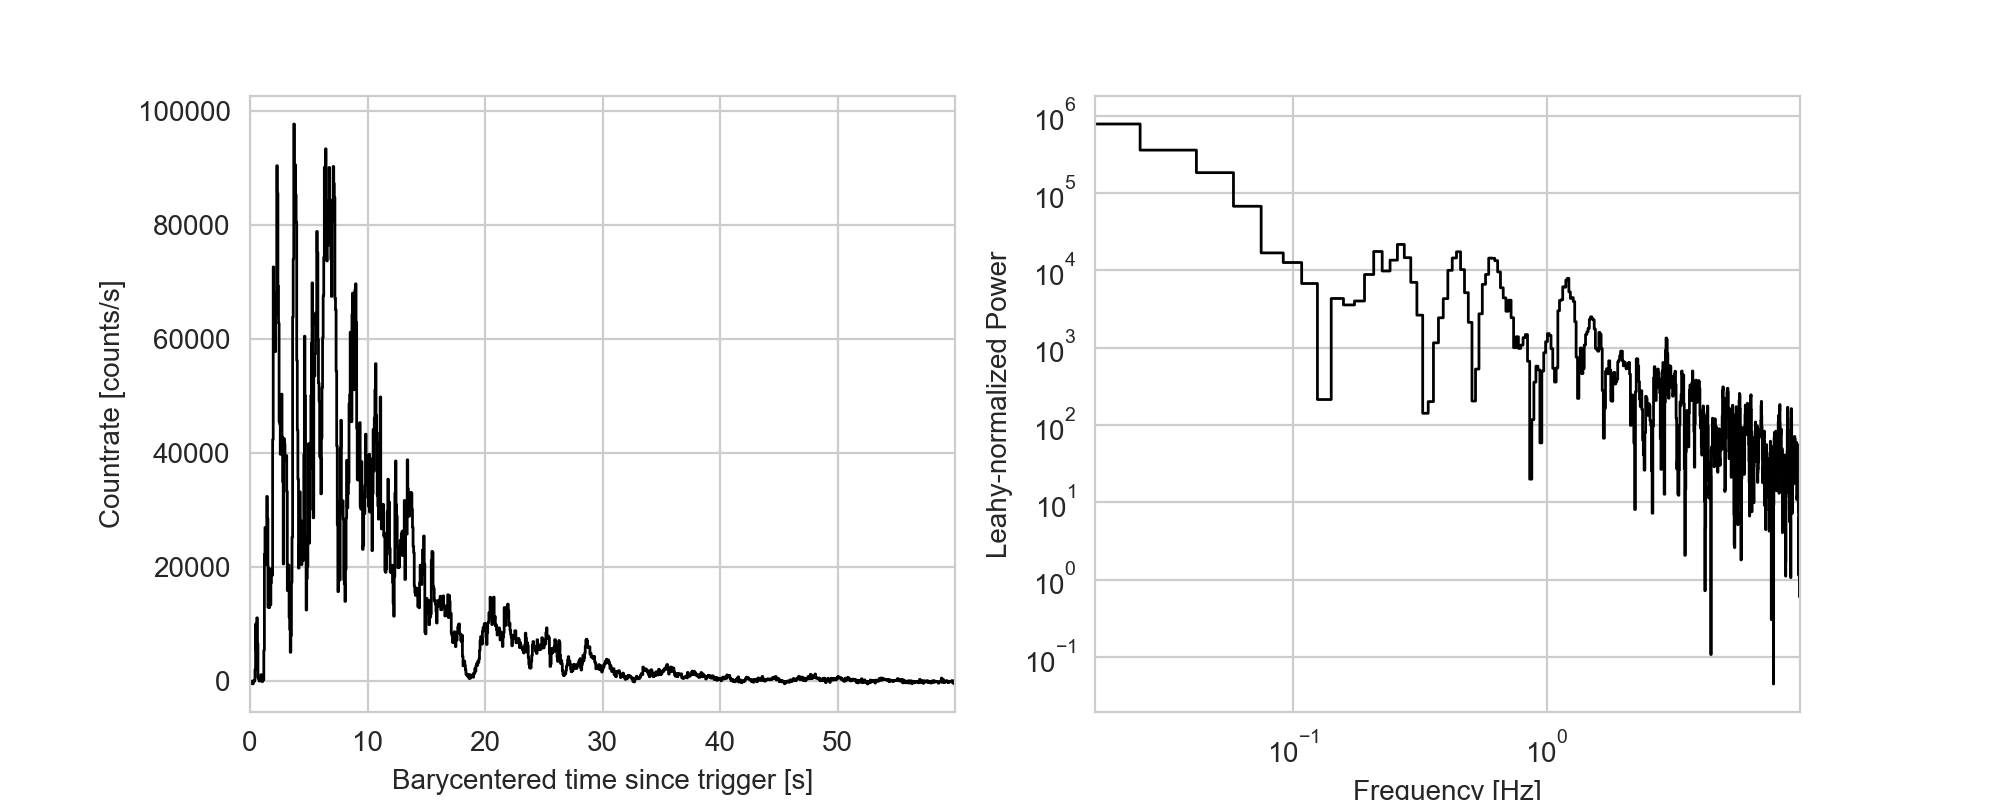

Text(0, 0.5, 'Leahy-normalized Power')

In [5]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.plot(lc.time, lc.countrate, lw=1, color="black", ds="steps-mid")
ax1.set_xlim(lc.time[0], lc.time[-1])
ax1.set_xlabel("Barycentered time since trigger [s]")
ax1.set_ylabel("Countrate [counts/s]")

ax2.loglog(ps.freq, ps.power, ds="steps-mid", lw=1, color="black")
ax2.set_xlim(ps.freq[0], ps.freq[-1])
ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel("Leahy-normalized Power")

## Gaussian Process Analysis on the Full Light Curve

Let's do the GP Analysis on the full light curve. We start by comparing a Damped Random Walk with a QPO model:

In [6]:
kernel_type = "RN"
mean_type = "skew_gaussian"
params_list = get_gp_params(kernel_type= kernel_type, mean_type = mean_type)

print("parameters list", params_list)

parameters list ['log_arn', 'log_crn', 'log_A', 't0', 'log_sig1', 'log_sig2']


In [7]:
times = lc.time - lc.time[0]
counts = lc.counts

In [8]:
counts.dtype

dtype('float64')

In [9]:
np.log(np.max(lc.counts))

8.493813769073922

In [10]:
total_time = times[-1] - times[0]
f = 1/(times[1]- times[0])
span = jnp.max(counts) - jnp.min(counts)

# The prior dictionary, with suitable tfpd prior distributions
prior_dict = {
    "t0": tfpd.Uniform(low = 0.0, high = 20.0),
    "log_A": tfpd.Uniform(5, 15),
    "log_sig1": tfpd.Uniform(-1, 3.5),
    "log_sig2": tfpd.Uniform(1, 4.0),
    #"log_freq": tfpd.Uniform(0.3, 5.0),
    #"log_aqpo": tfpd.Uniform(2, 20),
    #"log_cqpo": tfpd.Uniform(-10, 10),
    "log_arn": tfpd.Uniform(2, 20),
    "log_crn": tfpd.Uniform(-10, 10)
}

params_list2 = ["log_arn", "log_crn", "log_A", "t0", "log_sig1", "log_sig2"]

prior_model = get_prior(params_list2, prior_dict)

log_likelihood_model = get_log_likelihood(params_list2, kernel_type= kernel_type, mean_type = mean_type, 
                                          times = times, counts = counts)

In [11]:
from stingray.modeling.gpmodeling import GPResult

gpresult_rn = GPResult(lc = lc)
gpresult_rn.sample(prior_model = prior_model, likelihood_model = log_likelihood_model,
               max_samples=1e6)

INFO[2023-11-06 17:25:58,583]: Sanity check...
INFO[2023-11-06 17:25:59,445]: Sanity check passed


Simulation Complete


In [12]:
print("log Evidence: ", gpresult_rn.get_evidence())

log Evidence:  -8205.13778504663


In [13]:
import pickle

In [14]:
with open(datadir+"fermi_bgo_drw_deadtimecorr_res.pkl", "wb") as f:
    pickle.dump(gpresult_rn.results, f)

<IPython.core.display.Javascript object>


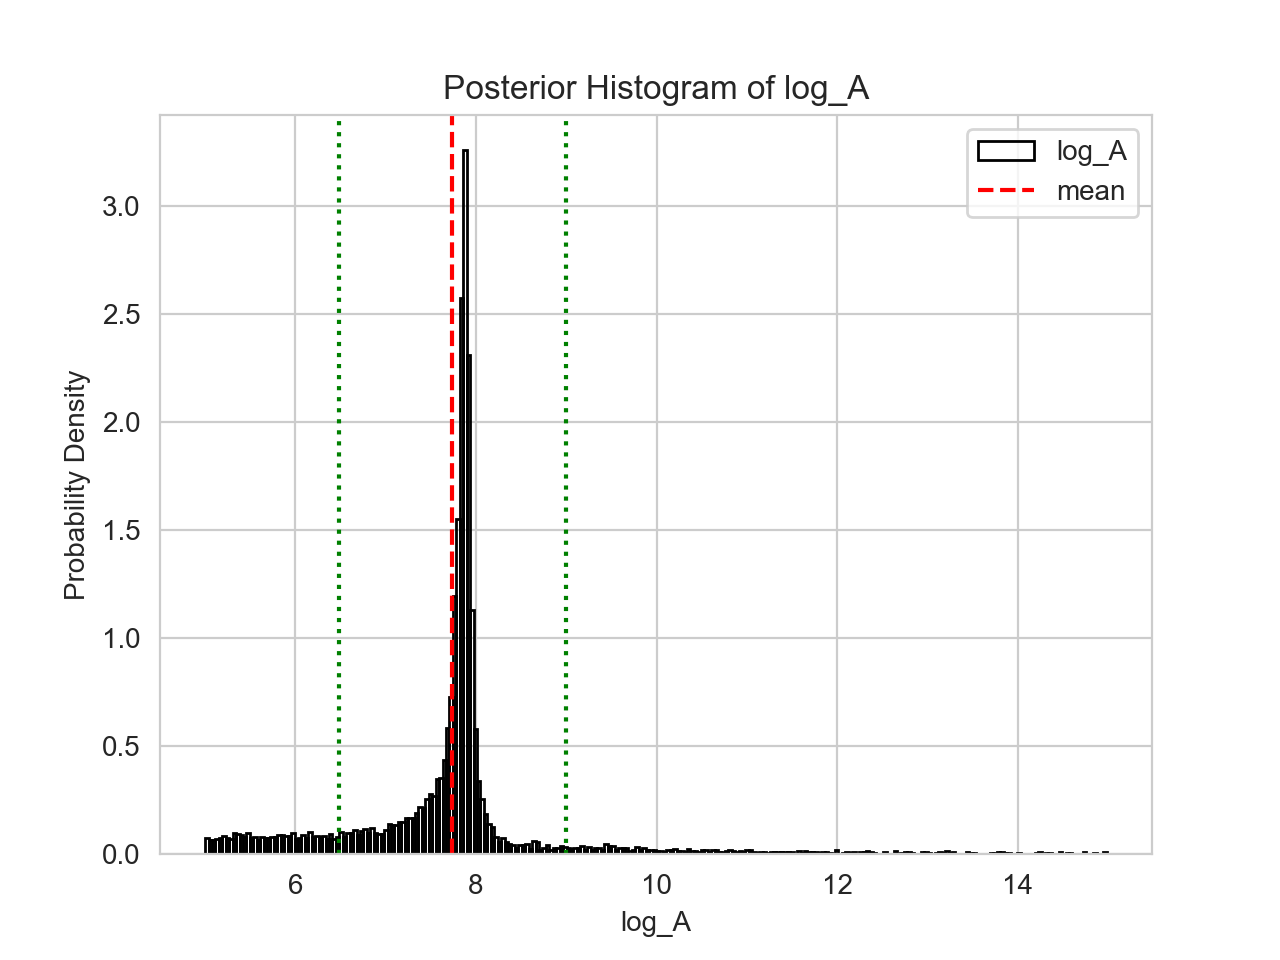

In [15]:
plt.figure()
plot = gpresult_rn.posterior_plot("log_A")
plt.show()

In [16]:
gpresult_rn.print_summary()

--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 1250107
# samples: 14000
# slices: 207000.0
# slices / acceptance: 18.0
# likelihood evals / sample: 89.3
# likelihood evals / slice: 5.9
--------
logZ=-8205.14 +- 0.2
H=8200.0
ESS=1692
--------
log_A: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_A: 7.866 +- 0.066 | 7.783 / 7.869 / 7.947 | 7.893 | 7.893
--------
log_arn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_arn: 12.27 +- 0.12 | 12.12 / 12.27 / 12.41 | 12.22 | 12.22
--------
log_crn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_crn: 0.96 +- 0.12 | 0.81 / 0.97 / 1.12 | 1.02 | 1.02
--------
log_sig1: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_sig1: -0.66 +- 0.3 | -0.95 / -0.74 / -0.3 | -0.98 | -0.98
--------
log_sig2: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_sig2: 2.181 +- 0.084 | 2.078 / 2.186 / 2.283

<IPython.core.display.Javascript object>


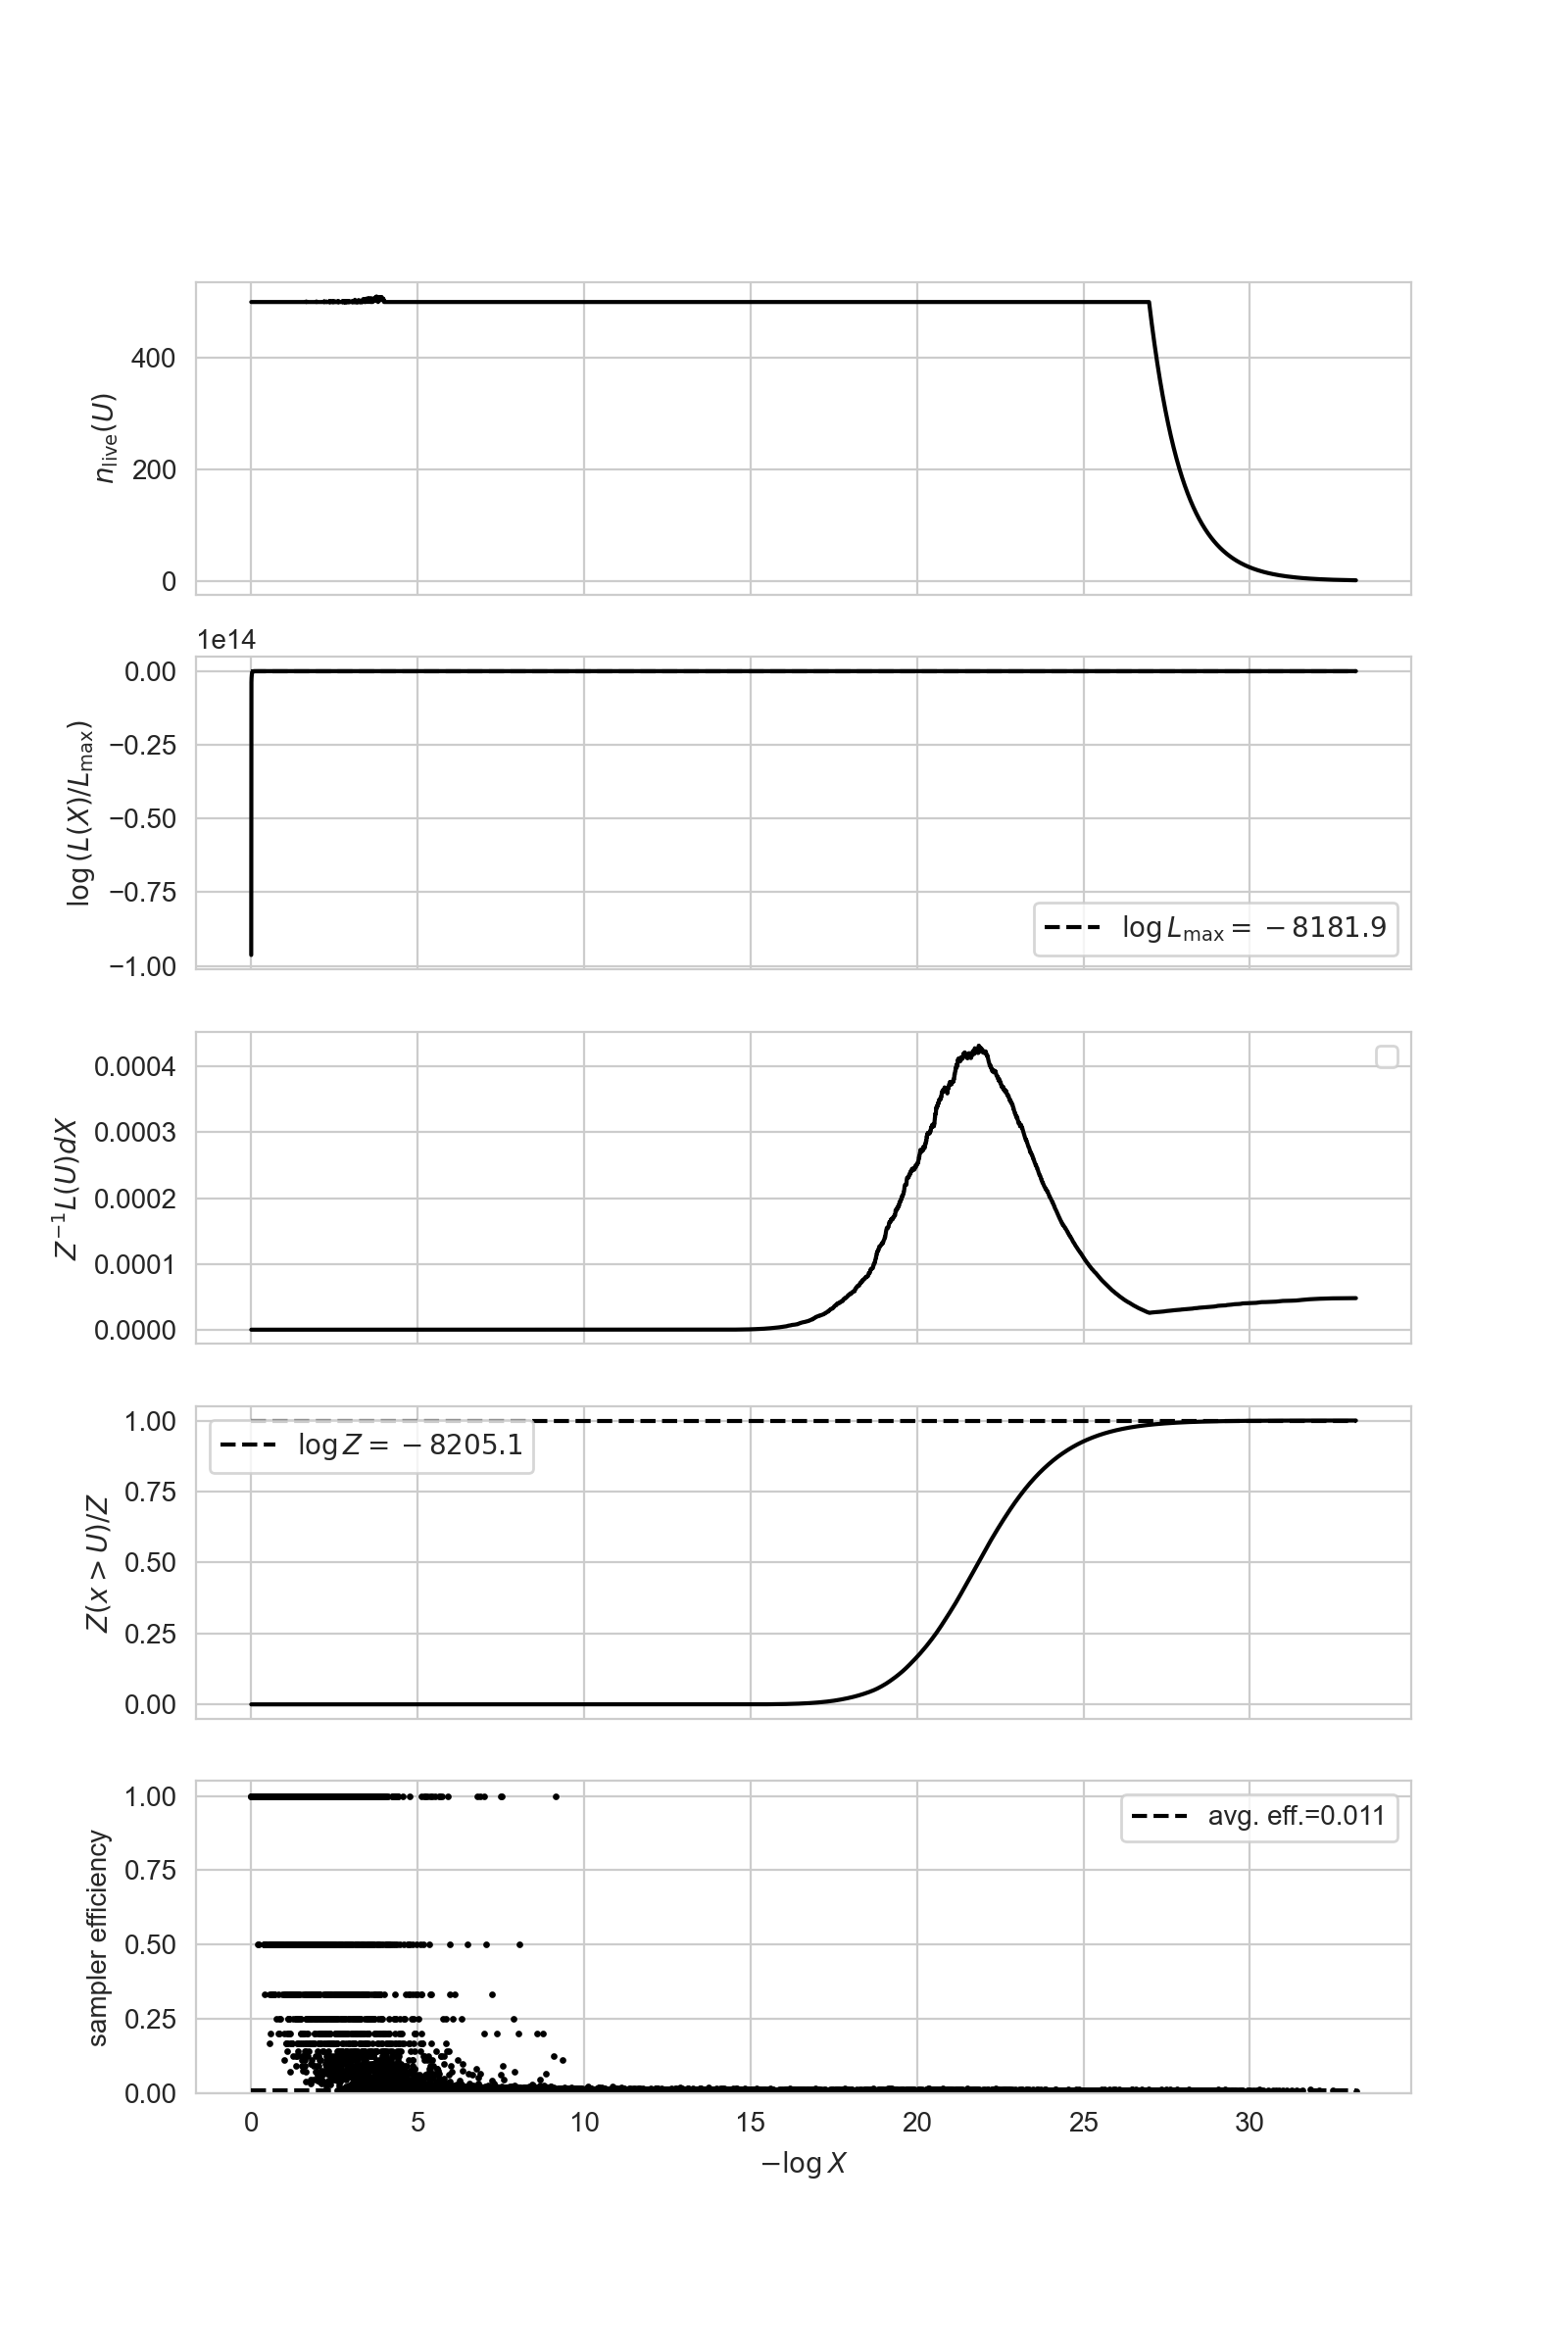

WARNING[2023-11-06 17:36:26,599]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [17]:
gpresult_rn.exact_ns.plot_diagnostics(gpresult_rn.results)

<IPython.core.display.Javascript object>


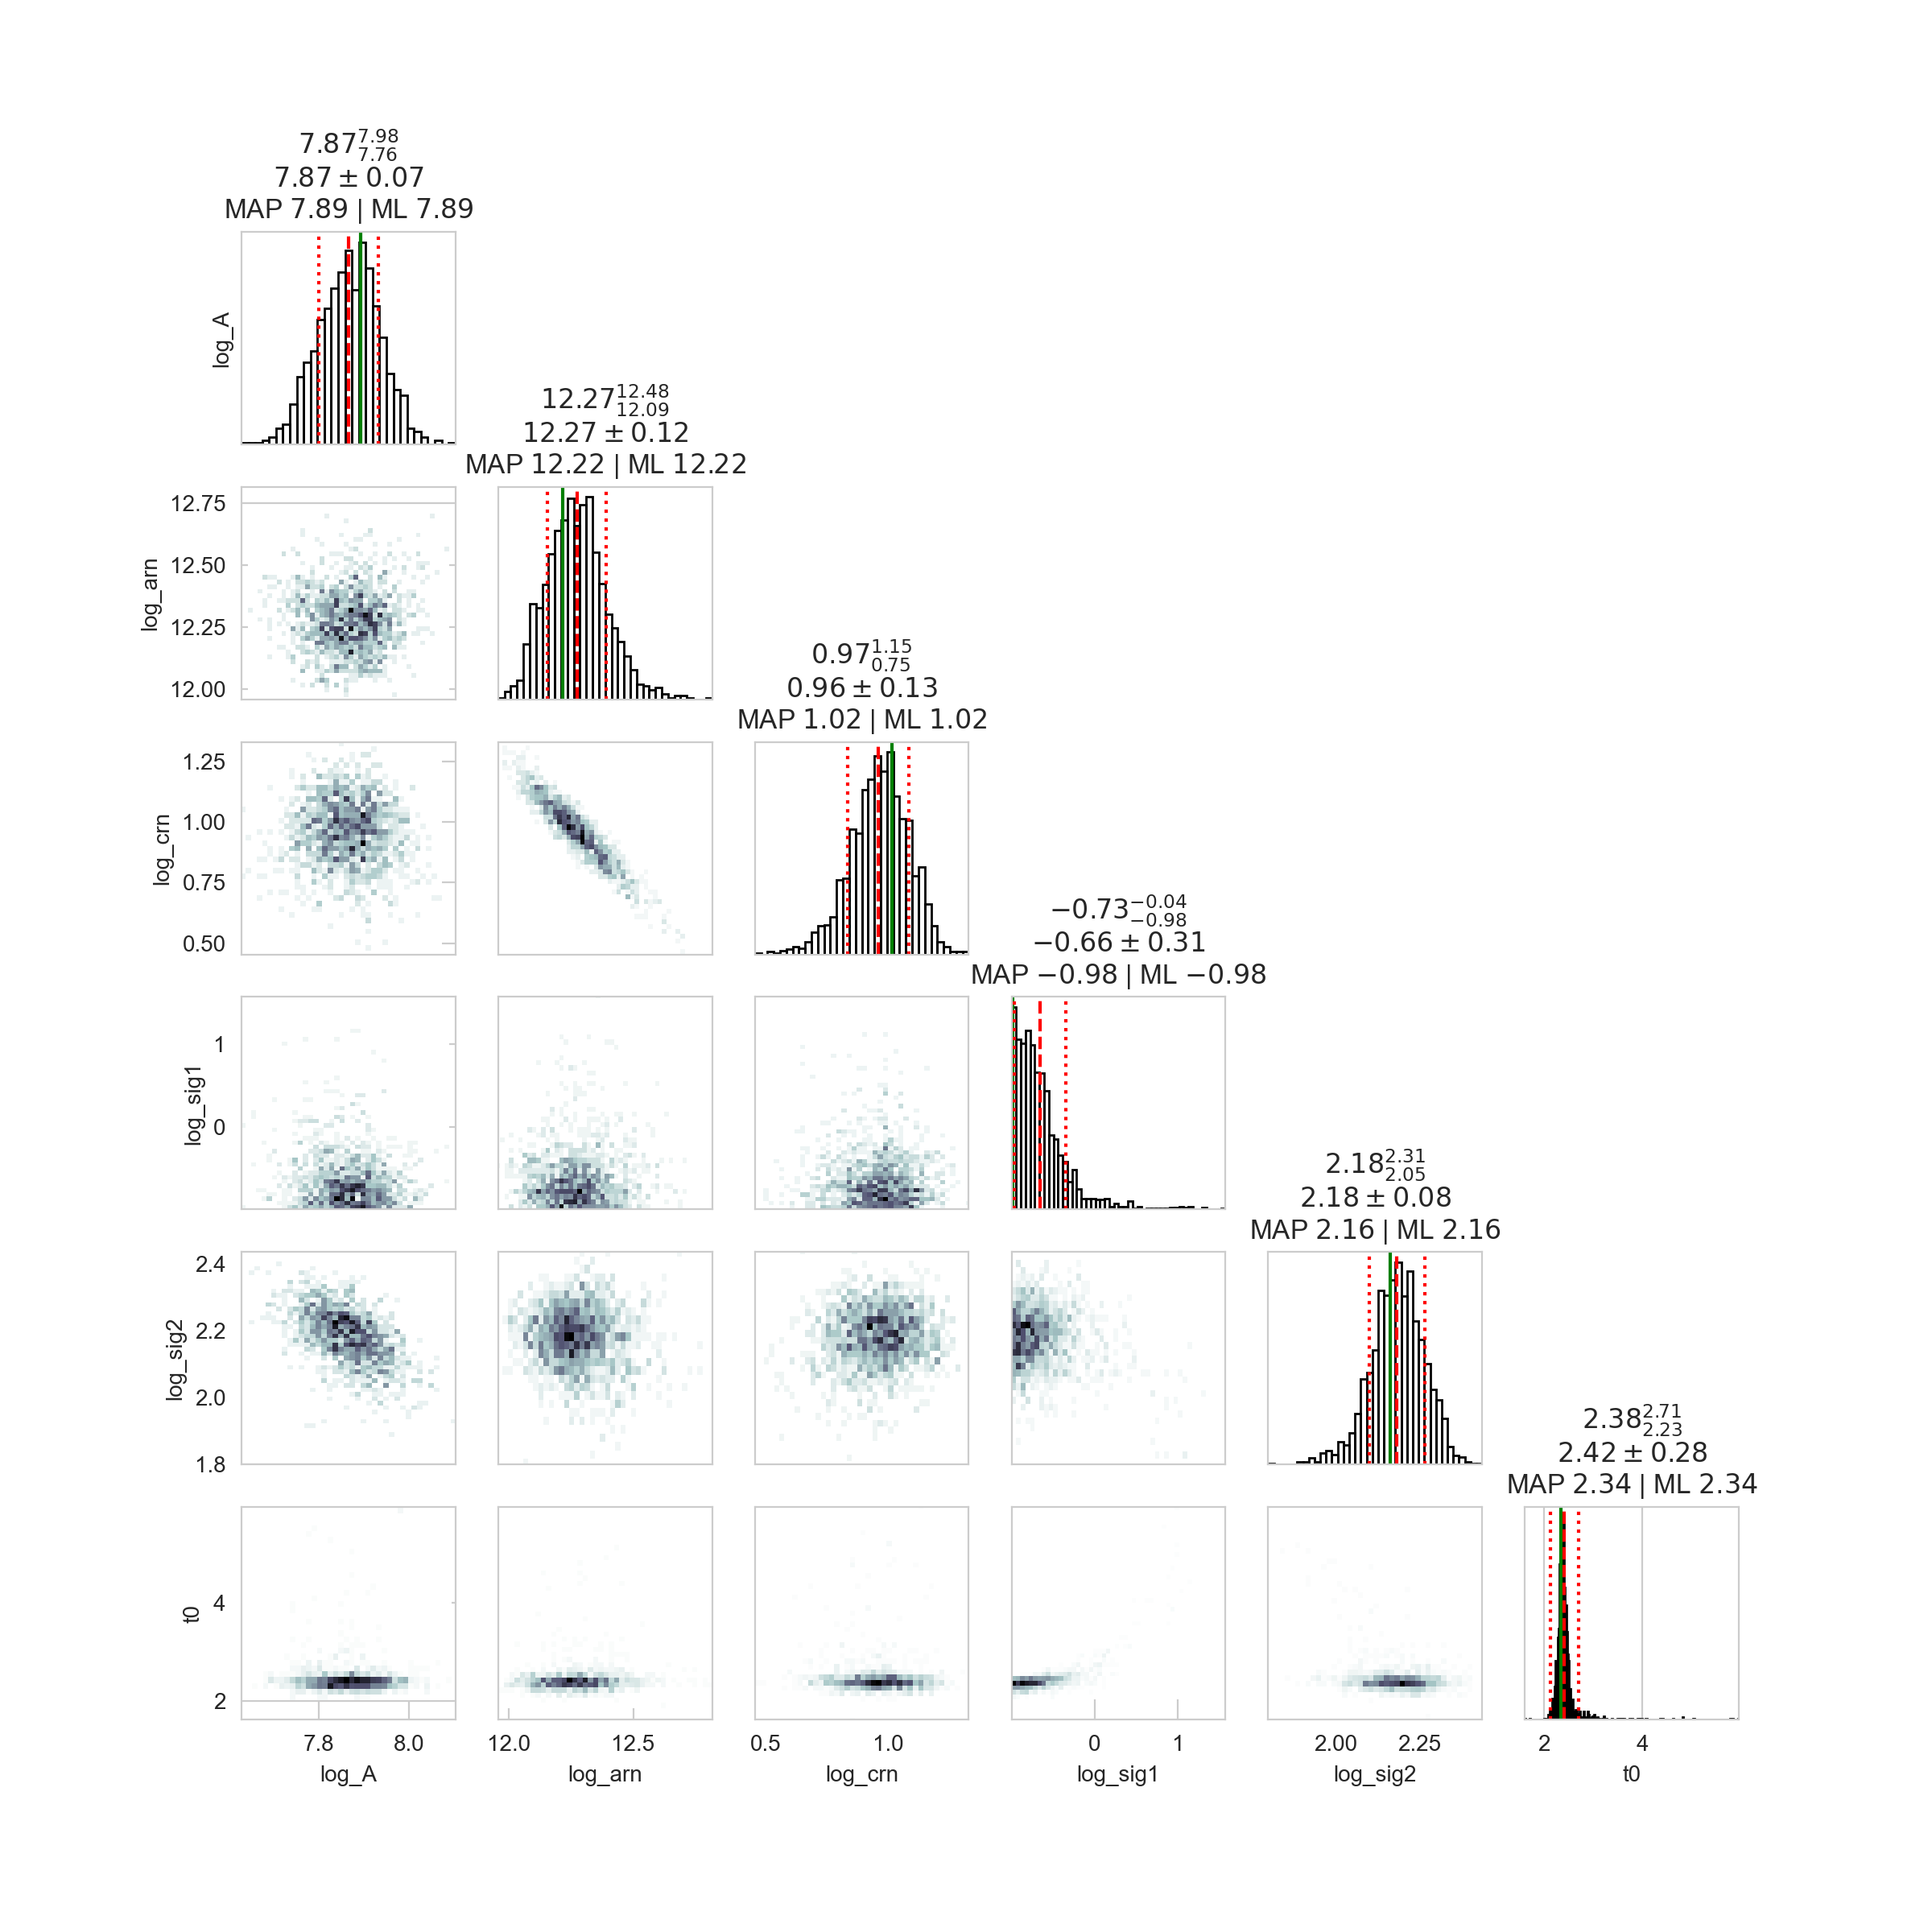

In [18]:
gpresult_rn.plot_cornerplot()

Let's write a function to plot the posterior predictive distribution (sort of):

In [20]:
def plot_posterior_predictive(lc, gpresult, kernel_type, mean_type, nmean=50, ngrid=1000, ax=None, rkey=None):
    """
    Plot the posterior predictive distribution.
    Will plot the maximum posterior for the Gaussian Process, and 
    `nsamples` random draws from the mean function.
    
    Parameters
    ----------
    lc : stingray.Lightcurve object
        The light curve with the time series data 
        being modelled
    
    nsresults : jaxns.Results object
        The results from the sampling
        
    kernel_type : str
        The kernel type used in the modeling
        
    mean_type : str
        The type of the mean function used
    
    nmean: int, default 50
        The number of samples to use for drawing the 
        posterior
        
    ngrid: int, default 1000
        The number of points in the linear grid to 
        use for plotting the Gaussian Process
    
    ax : matplotlib.Axes object, default None
        A matplotlib.Axes object to plot into. If none is 
        given, a new Figure object will be created
        
    rkey : jax.randomPRNGKey object
        A random key for setting the sampling. If None,
        set to random.PRNGKey(1234)
    
    Returns
    -------
    ax : matplotlib.Axes object
        The matplotlib.axes object that the plot is 
        drawn in
    """
    if rkey is None:
        rkey = random.PRNGKey(1234)

    log_p = gpresult.results.log_dp_mean #log-prob
    nsamples = gpresult.results.total_num_samples # number of samples

    # array for resampled samples
    samples_resampled = {}

    # go through samples, resample with weights to get 
    # a weighted posterior sample
    for name in gpresult.results.samples.keys():
        samples = gpresult.results.samples[name]

        weights = jnp.where(jnp.isfinite(samples), jnp.exp(log_p), 0.0)
        log_weights = jnp.where(jnp.isfinite(samples), log_p, -jnp.inf)
        sr = resample(
            rkey, samples, log_weights, S=max(10, int(gpresult.results.ESS)), replace=True
    )
        samples_resampled[name] = sr

    print("Resampling done, calculating maximum posterior model ...")
    # split into samples belonging to the kernel, and samples 
    # belonging to the mean function
    kernel_params = stingray.modeling.gpmodeling._get_kernel_params(kernel_type)
    mean_params = stingray.modeling.gpmodeling._get_mean_params(mean_type)

    mean_samples = dict((k, samples_resampled[k]) for k in mean_params)

    maxpost_log = gpresult.get_max_posterior_parameters()

    sk_maxpost_log = dict((k, maxpost_log[k]) for k in kernel_params)
    sm_maxpost_log = dict((k, maxpost_log[k]) for k in mean_params)

    sk_maxpost, sm_maxpost = {}, {}
    for params in kernel_params:
        if params[0:4] == "log_":
            sk_maxpost[params[4:]] = jnp.exp(sk_maxpost_log[params])
        else:
            sk_maxpost[params] = sk_maxpost_log[params]

    for params in mean_params:
        if params[0:4] == "log_":
            sm_maxpost[params[4:]] = jnp.exp(sm_maxpost_log[params])
        else:
            sm_maxpost[params] = sm_maxpost_log[params]
            
    print(mean_type)
    kernel = get_kernel(kernel_type=kernel_type, kernel_params=sk_maxpost)
    mean = get_mean(mean_type=mean_type, mean_params=sm_maxpost)
    
    gp = GaussianProcess(kernel, lc.time, mean_value=mean(lc.time))
    tgrid = np.linspace(lc.time[0], lc.time[-1], ngrid)
    _, cond = gp.condition(lc.counts, tgrid)

    mu = cond.loc + mean(tgrid)
    std = np.sqrt(cond.variance)

    print("GP calculated, plotting GP and data ...")
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8,4))

    ax.errorbar(lc.time, lc.counts, yerr=np.sqrt(lc.counts), 
                fmt="o", markersize=2, color="black",
                label="Observations")
    ax.plot(tgrid, mu, color="C0", label="Gaussian Process Maximum Posterior")
    ax.fill_between(tgrid, mu + std, mu - std, color="C0", alpha=0.3)

    idx_all = np.random.choice(np.arange(0,int(gpresult.results.ESS), 1.0, dtype=int), 
                               size=nmean,
                               replace=False)
    print("calculating and plotting mean functions ...")
    for i, idx in enumerate(idx_all):
        #sk_log = dict((k, kernel_samples[k][idx]) for k in kernel_params)
        sm_log = dict((k, mean_samples[k][idx]) for k in mean_params)
        sm = {}
        for params in mean_params:
            if params[0:4] == "log_":
                sm[params[4:]] = jnp.exp(sm_log[params])
            else:
                sm[params] = sm_log[params]

        mean = get_mean(mean_type=mean_type, mean_params=sm)
        mean_vals = mean(times)
        
        # legend only for the first line being drawn
        if i == 0:
            ax.plot(times, mean_vals, color="orange", 
                    alpha=0.1, label="Mean function posterior draws")  
        else:
            ax.plot(times, mean_vals, color="orange", alpha=0.1)

    # update legend opacity
    leg = ax.legend()
    for lh in leg.legendHandles: 
        lh.set_alpha(1)

    return ax

<IPython.core.display.Javascript object>


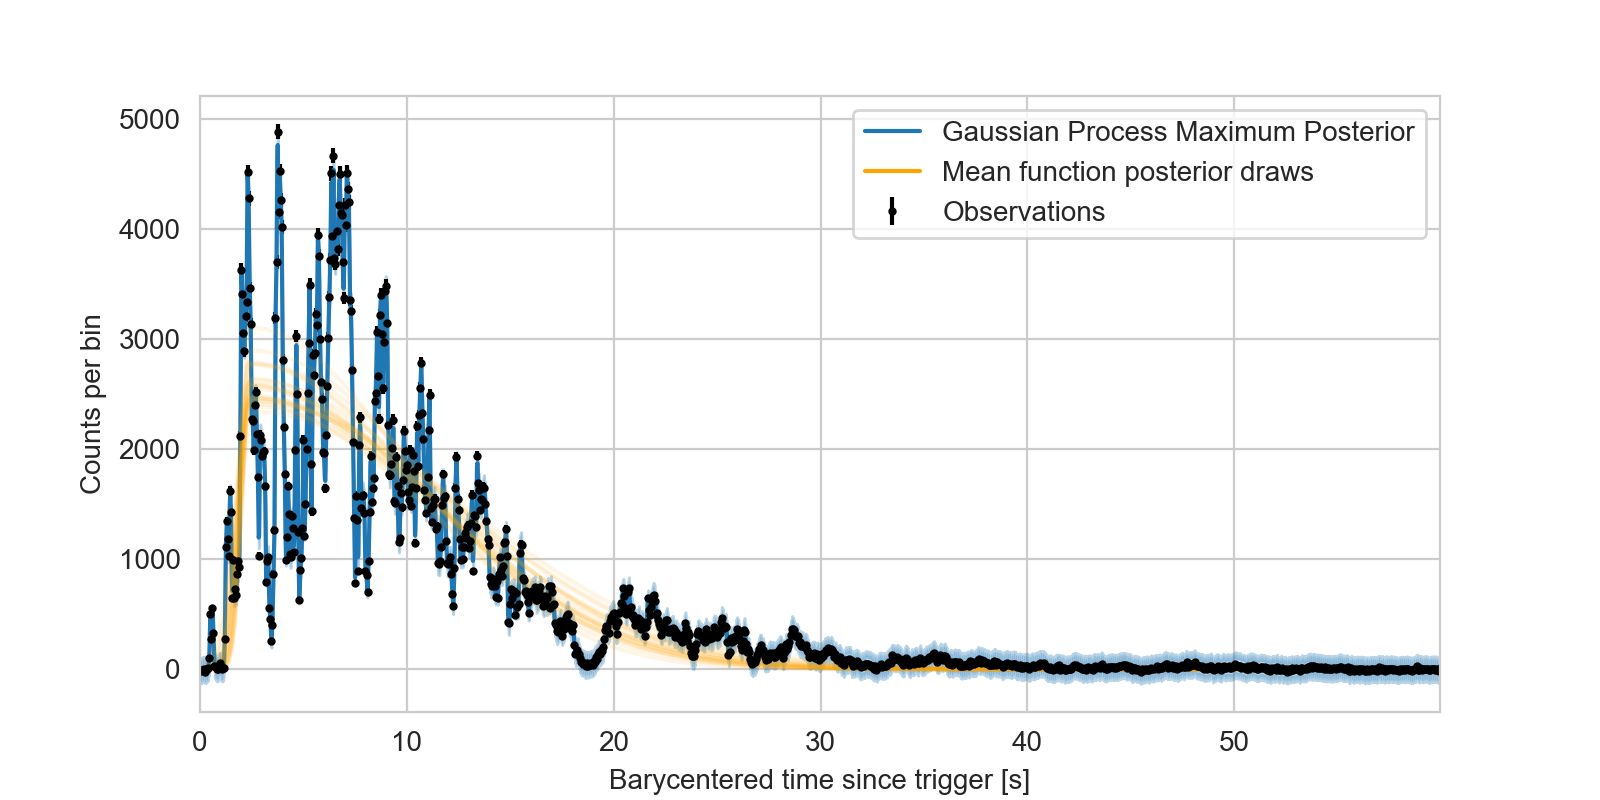

Resampling done, calculating maximum posterior model ...
skew_gaussian
GP calculated, plotting GP and data ...
calculating and plotting mean functions ...


Text(0, 0.5, 'Counts per bin')

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax = plot_posterior_predictive(lc, gpresult_rn, kernel_type, mean_type, 
                               nmean=20, ngrid=3000, ax=ax, rkey=None)

ax.set_xlim(lc.time[0], lc.time[-1])
ax.set_xlabel("Barycentered time since trigger [s]")
ax.set_ylabel("Counts per bin")

## Red Noise + QPO

let's do a model with both red noise and a QPO:

In [24]:
kernel_type = "QPO_plus_RN"
mean_type = "skew_gaussian"
params_list = get_gp_params(kernel_type= kernel_type, mean_type = mean_type)

print("parameters list", params_list)

parameters list ['log_arn', 'log_crn', 'log_aqpo', 'log_cqpo', 'log_freq', 'log_A', 't0', 'log_sig1', 'log_sig2']


In [25]:
total_time = times[-1] - times[0]
f = 1/(times[1]- times[0])
span = jnp.max(counts) - jnp.min(counts)

# The prior dictionary, with suitable tfpd prior distributions
prior_dict = {
    "t0": tfpd.Uniform(low = 0.0, high = 20.0),
    "log_A": tfpd.Uniform(5, 15),
    "log_sig1": tfpd.Uniform(-1, 3.5),
    "log_sig2": tfpd.Uniform(1, 4.0),
    "log_freq": tfpd.Uniform(np.log(0.1), np.log(2.5)),
    "log_aqpo": tfpd.Uniform(2, 20),
    "log_cqpo": tfpd.Uniform(-10, 10),
    "log_arn": tfpd.Uniform(2, 20),
    "log_crn": tfpd.Uniform(-10, 10)
}

#params_list2 = ["log_arn", "log_crn", "log_A", "t0", "log_sig1", "log_sig2"]

prior_model = get_prior(params_list, prior_dict)

log_likelihood_model = get_log_likelihood(params_list, kernel_type= kernel_type, mean_type = mean_type, 
                                          times = times, counts = counts)

In [26]:
from stingray.modeling.gpmodeling import GPResult

gpresult_qporn = GPResult(lc = lc)
gpresult_qporn.sample(prior_model = prior_model, likelihood_model = log_likelihood_model,
               max_samples=1e6, num_live_points=2000)

INFO[2023-11-06 17:36:59,024]: Sanity check...
INFO[2023-11-06 17:36:59,360]: Sanity check passed


Simulation Complete


In [27]:
print("log Evidence: ", gpresult_rn.get_evidence())

log Evidence:  -8205.13778504663


In [28]:
print("log Evidence: ", gpresult_qporn.get_evidence())

log Evidence:  -8198.480221798909


In [29]:
gpresult_qporn.get_evidence() - gpresult_rn.get_evidence()

Array(6.65756325, dtype=float64)

In [30]:
with open(datadir+"fermi_bgo_drw_qpo_deadtimecorr_res.pkl", "wb") as f:
    pickle.dump(gpresult_qporn.results, f)

<IPython.core.display.Javascript object>


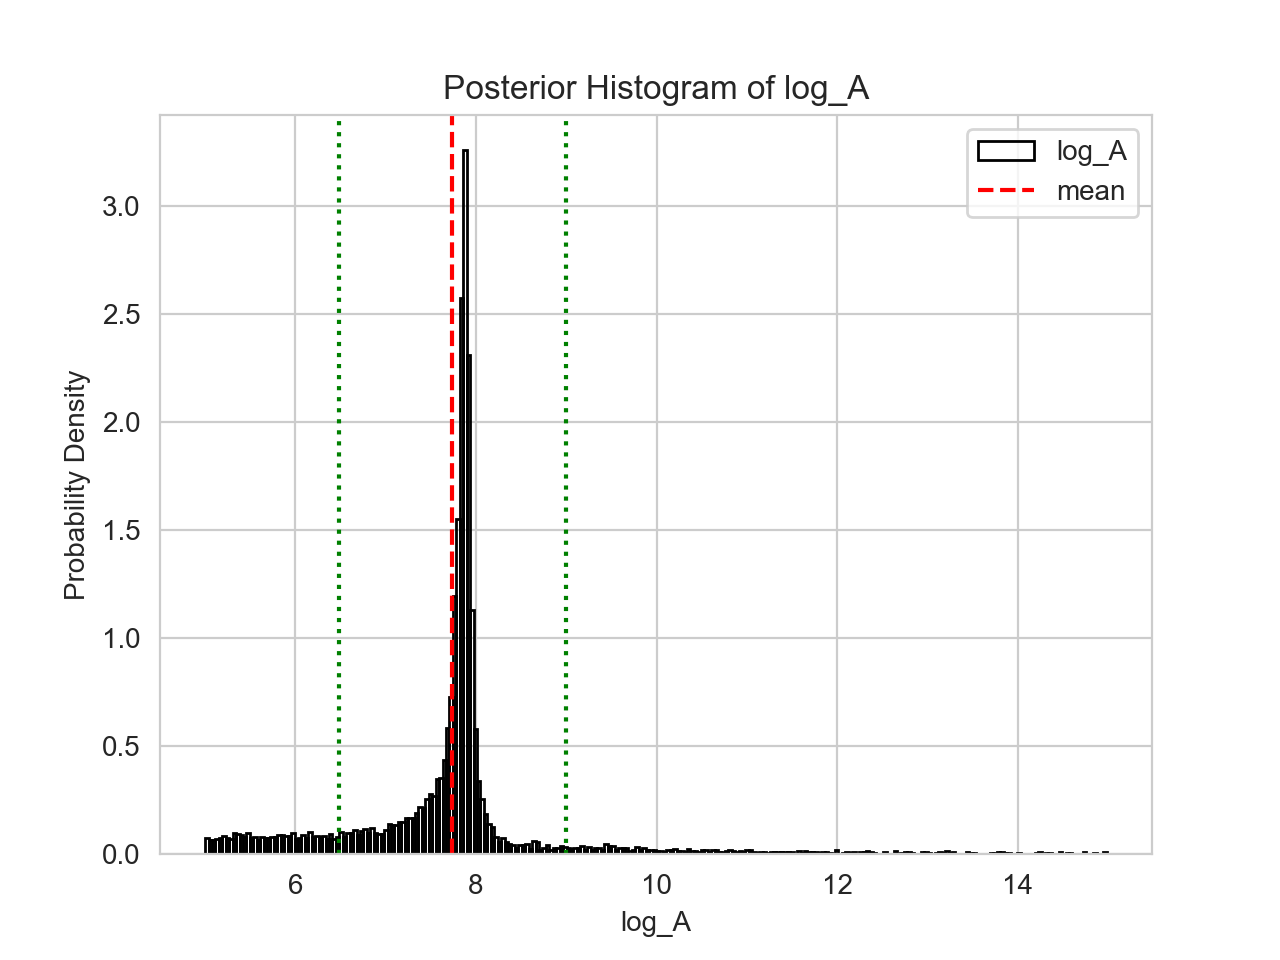

In [31]:
plt.figure()
plot = gpresult_rn.posterior_plot("log_A")
plt.show()

In [32]:
gpresult_qporn.print_summary()

--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 10701897
# samples: 76000
# slices: 1782000.0
# slices / acceptance: 27.0
# likelihood evals / sample: 140.8
# likelihood evals / slice: 5.9
--------
logZ=-8198.48 +- 0.12
H=8200.0
ESS=13001
--------
log_A: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_A: 7.848 +- 0.067 | 7.762 / 7.849 / 7.931 | 7.881 | 7.881
--------
log_aqpo: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_aqpo: 10.9 +- 1.1 | 9.8 / 10.7 / 12.4 | 10.2 | 10.2
--------
log_arn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_arn: 12.12 +- 0.82 | 12.05 / 12.2 / 12.38 | 12.13 | 12.13
--------
log_cqpo: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_cqpo: -3.5 +- 1.5 | -5.4 / -3.4 / -1.7 | -3.1 | -3.1
--------
log_crn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_crn: 0.95 +- 0.58 | 0.78 / 0.97 / 1.13 | 1.05 

<IPython.core.display.Javascript object>


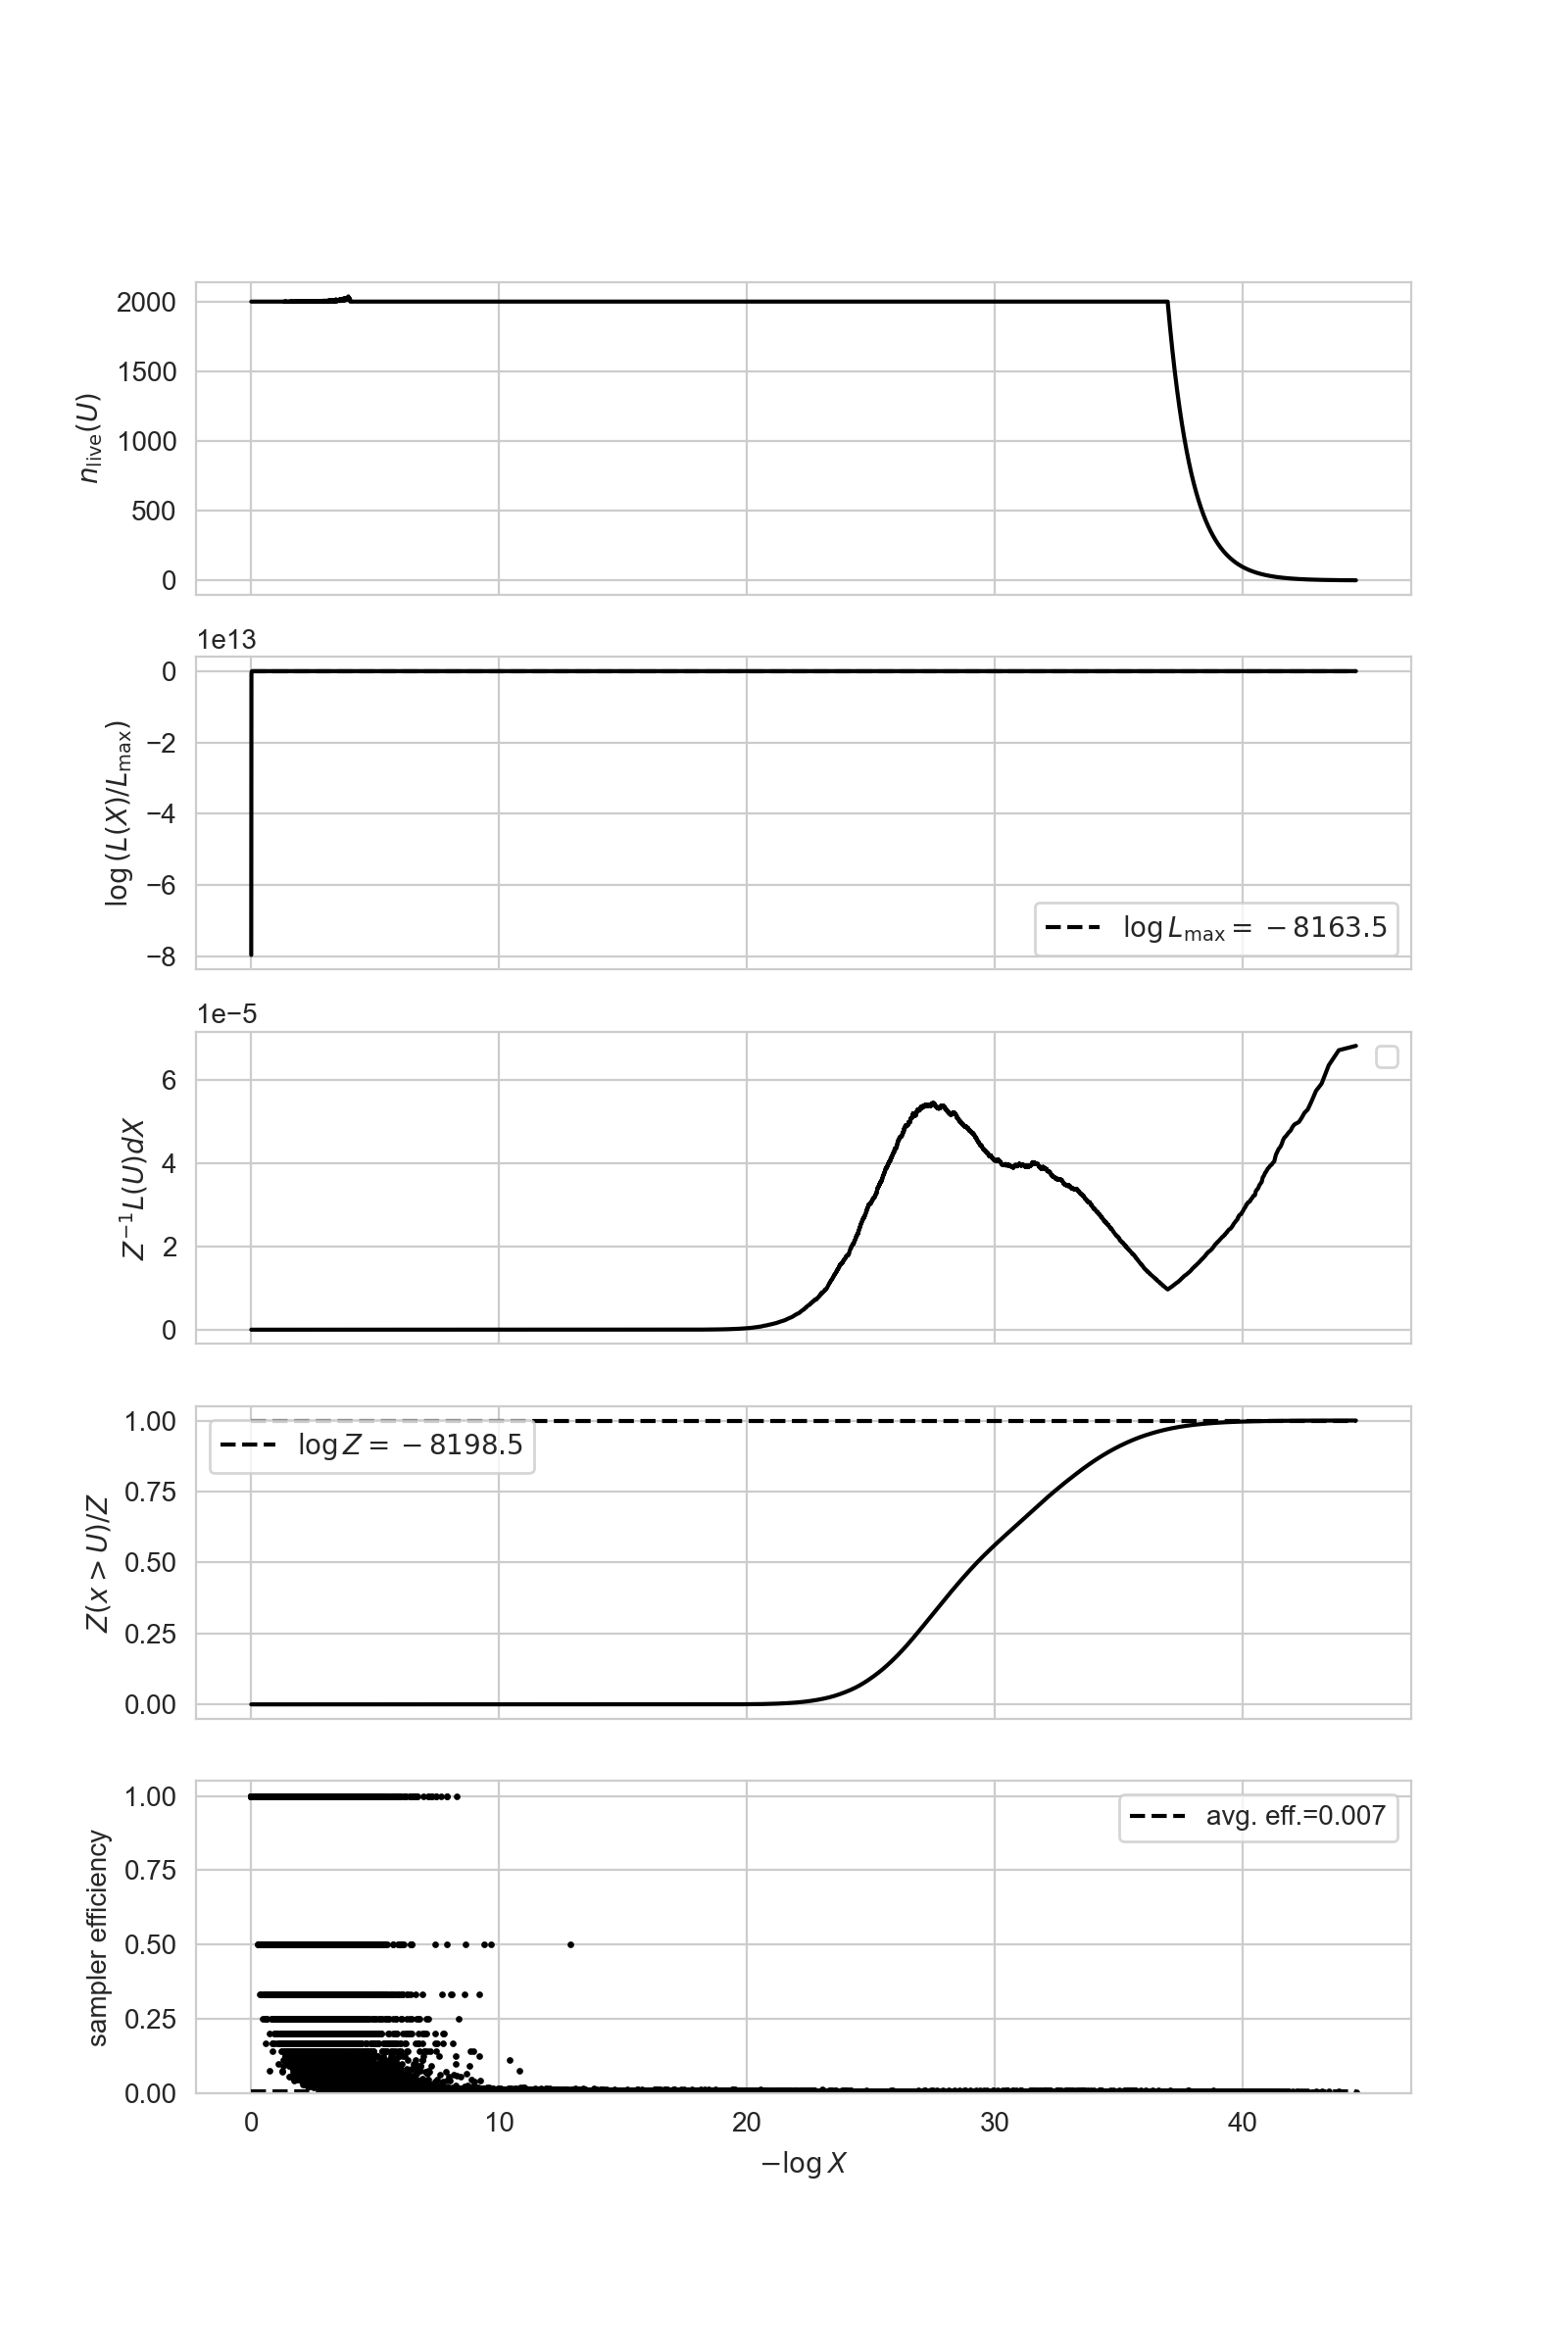

WARNING[2023-11-06 18:40:59,530]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [33]:
gpresult_qporn.exact_ns.plot_diagnostics(gpresult_qporn.results)

<IPython.core.display.Javascript object>


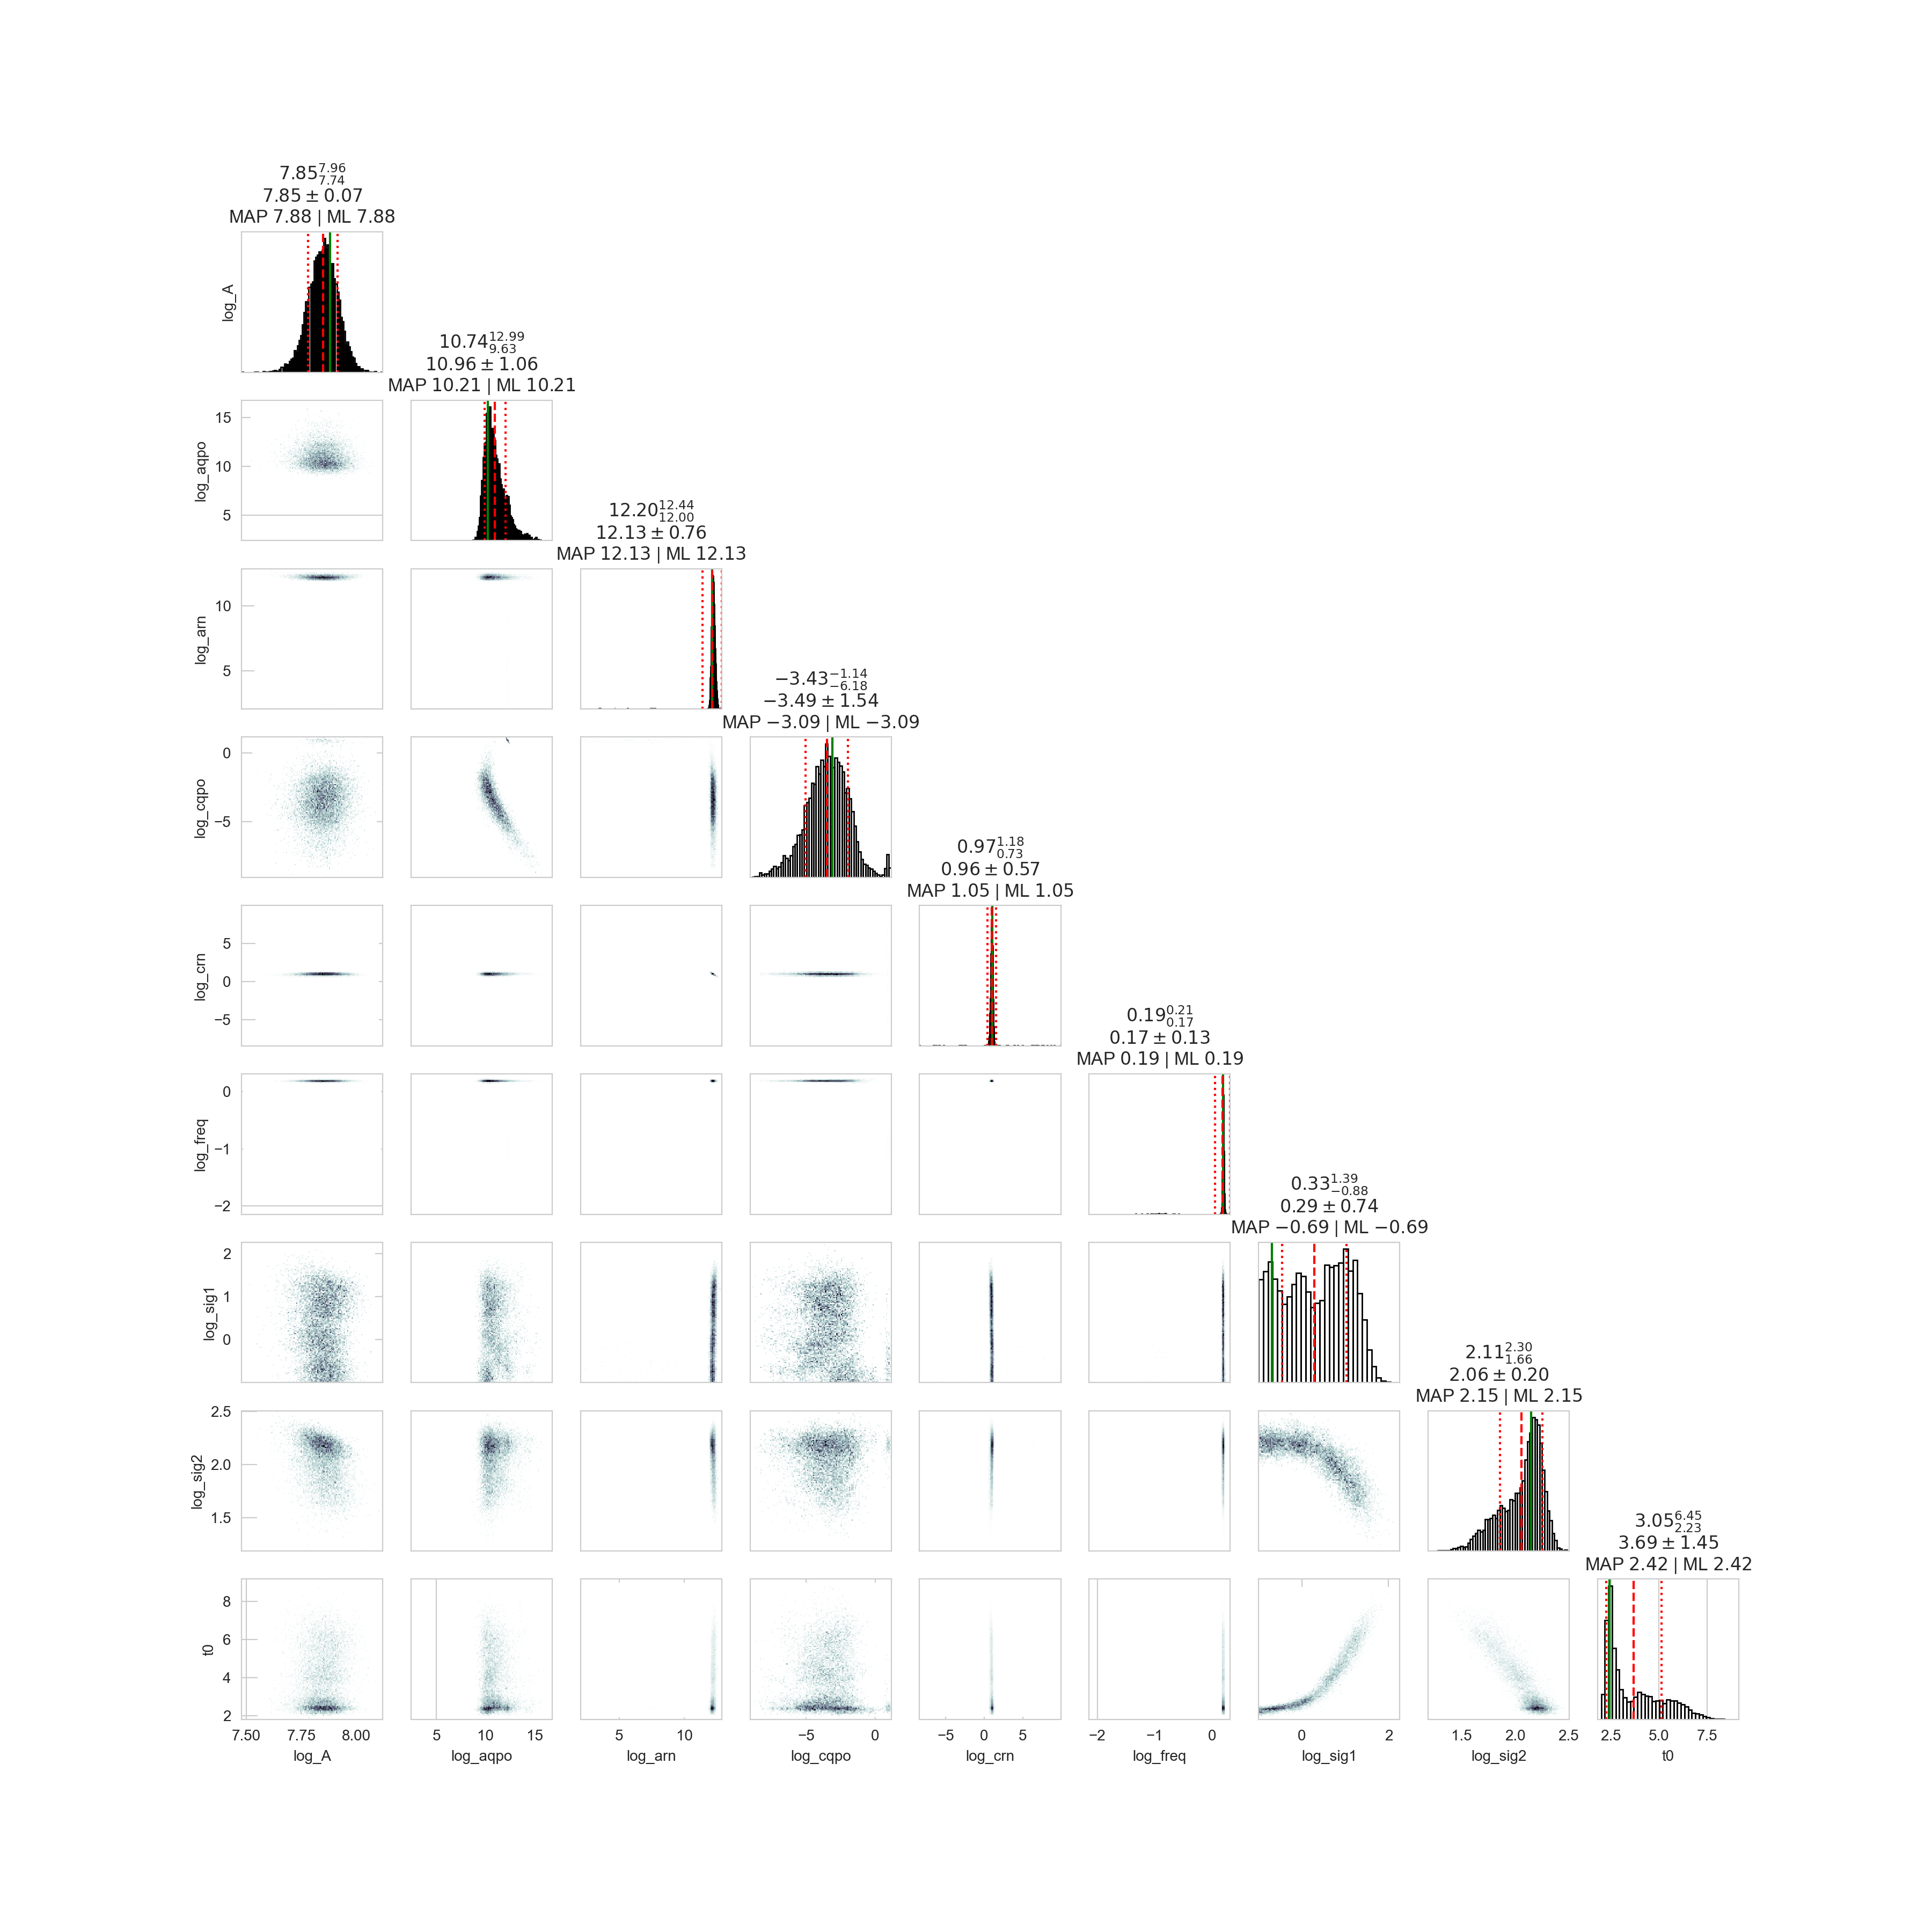

In [36]:
gpresult_qporn.plot_cornerplot()

<IPython.core.display.Javascript object>


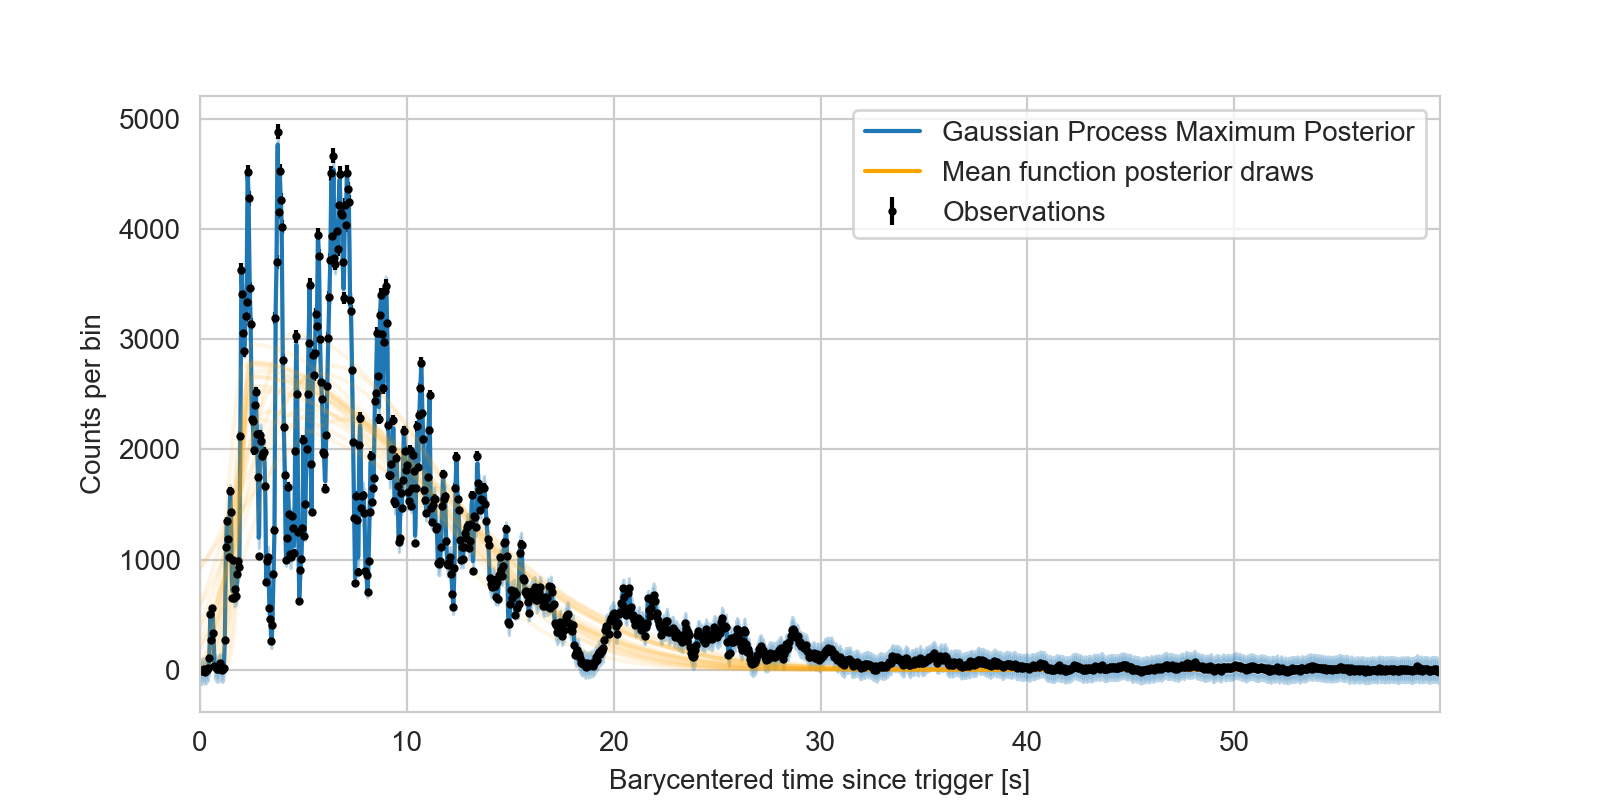

Resampling done, calculating maximum posterior model ...
skew_gaussian
GP calculated, plotting GP and data ...
calculating and plotting mean functions ...


Text(0, 0.5, 'Counts per bin')

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax = plot_posterior_predictive(lc, gpresult_qporn, kernel_type, mean_type, 
                               nmean=20, ngrid=3000, ax=ax, rkey=None)

ax.set_xlim(lc.time[0], lc.time[-1])
ax.set_xlabel("Barycentered time since trigger [s]")
ax.set_ylabel("Counts per bin")

Okay, that looks better. Phew. Let's plot the QPO frequency:

<IPython.core.display.Javascript object>


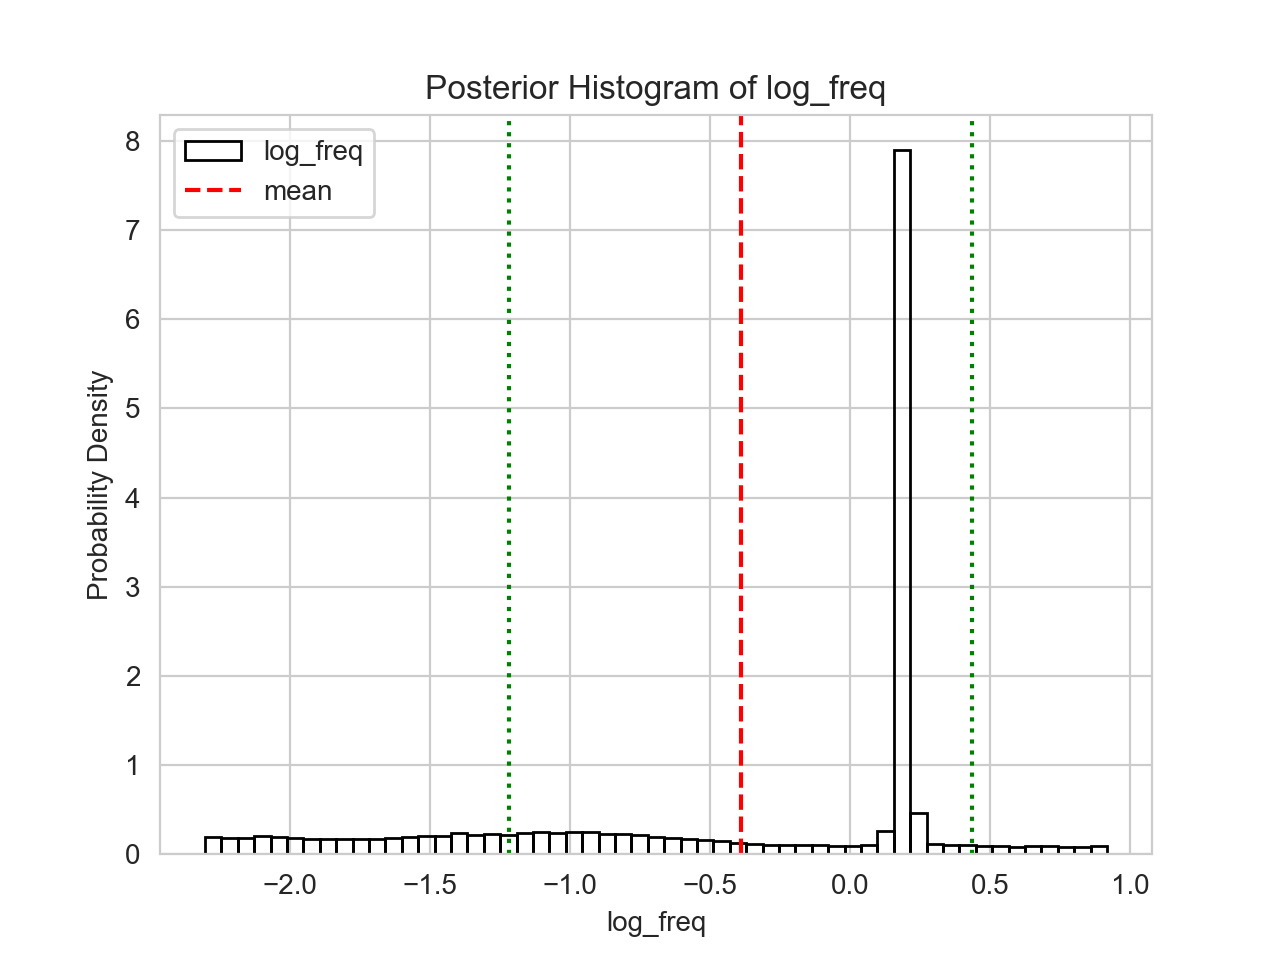

<module 'matplotlib.pyplot' from '/opt/miniconda3/envs/grbsearch/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [38]:
plt.figure()
gpresult_qporn.posterior_plot("log_freq")

In [39]:
samples = gpresult_qporn.results.samples["log_freq"]
rkey = random.PRNGKey(1234)

log_p = gpresult_qporn.results.log_dp_mean #log-prob
nsamples = gpresult_qporn.results.total_num_samples # number of samples

weights = jnp.where(jnp.isfinite(samples), jnp.exp(log_p), 0.0)
log_weights = jnp.where(jnp.isfinite(samples), log_p, -jnp.inf)
freq_resampled = resample(
    rkey, samples, log_weights, S=max(10, int(gpresult_qporn.results.ESS)), replace=True
)

In [40]:
freq = np.exp(freq_resampled)
period = 1.0/freq

In [41]:
period

array([0.81937922, 0.8293204 , 0.82869172, ..., 0.82703846, 0.81670362,
       0.83953062])

<IPython.core.display.Javascript object>


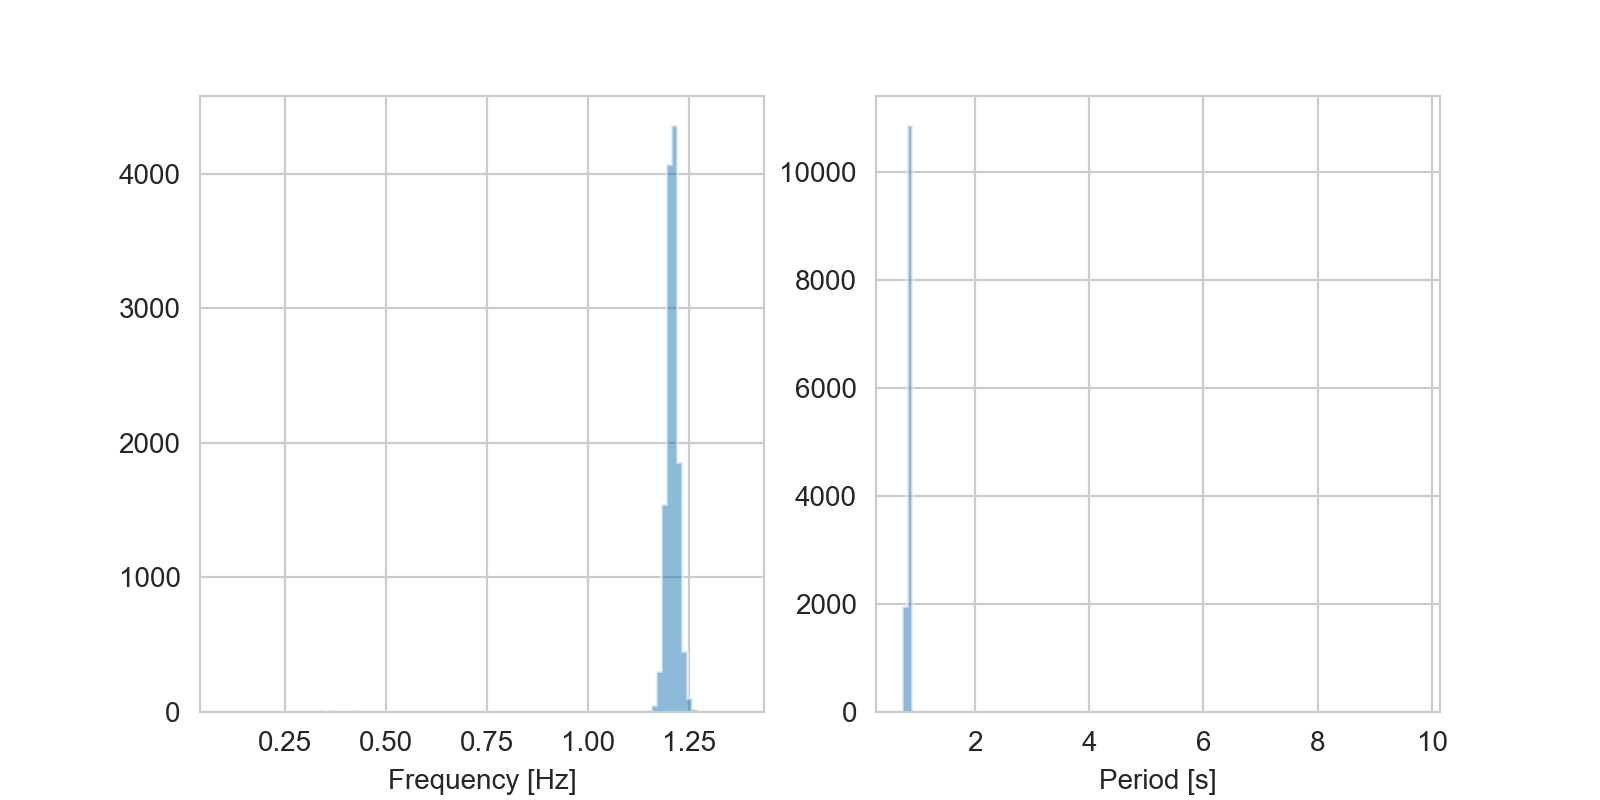

Text(0.5, 0, 'Period [s]')

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

ax1.hist(freq, bins=100, histtype="stepfilled", alpha=0.5)
ax1.set_xlabel("Frequency [Hz]")

ax2.hist(period, bins=100, histtype="stepfilled", alpha=0.5)
ax2.set_xlabel("Period [s]")

In [43]:
np.log10(np.exp(gpresult_qporn.get_evidence() - gpresult_rn.get_evidence()))

2.8913429814073632

## Cutting Out the Saturated Parts

<IPython.core.display.Javascript object>


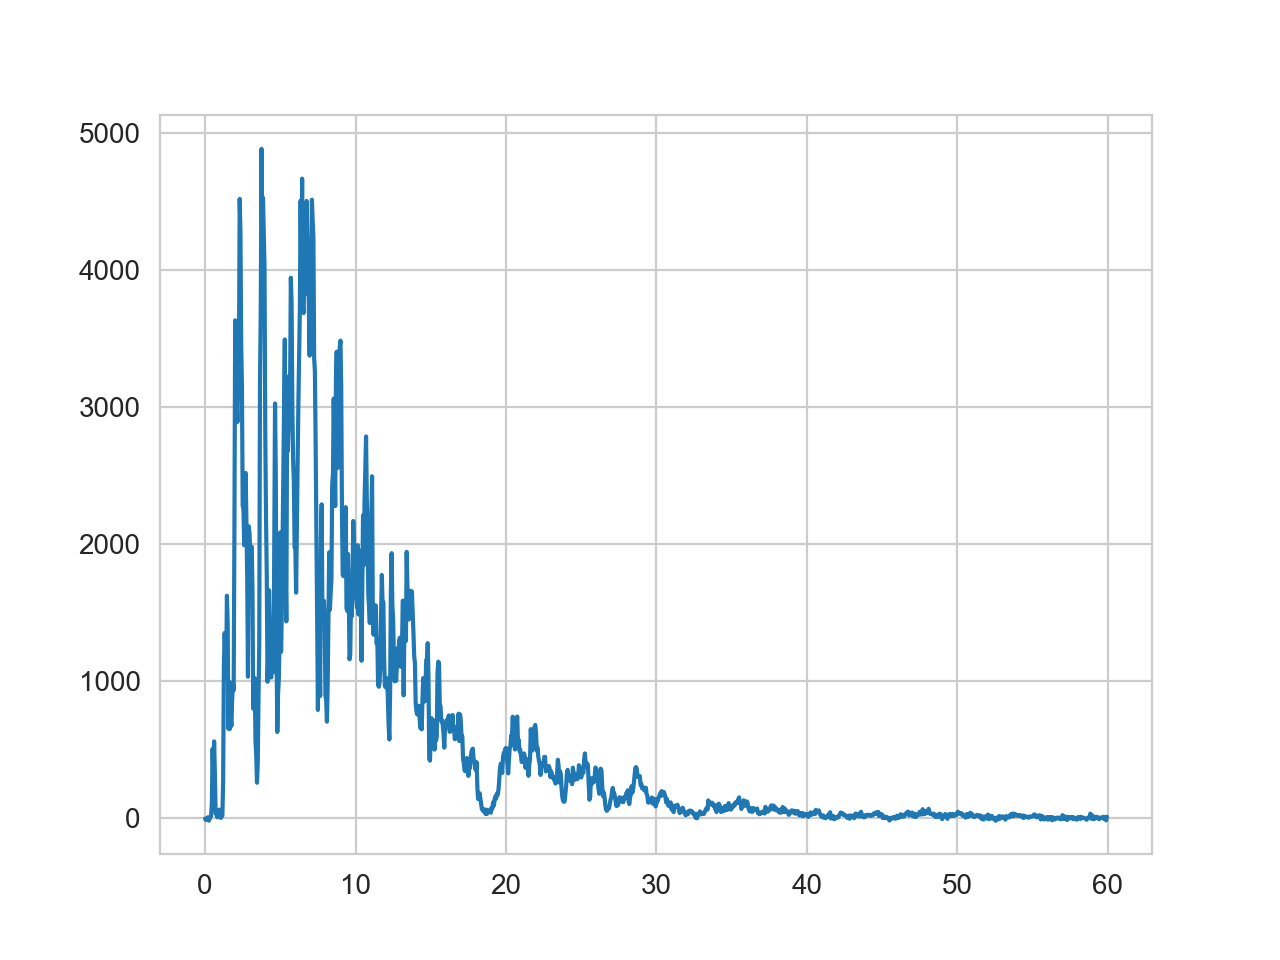

In [44]:
plt.figure()
plt.plot(lc.time, lc.counts)

In [45]:
barytime

array([6.99896606e+08, 6.99896606e+08, 6.99896606e+08, ...,
       6.99896751e+08, 6.99896751e+08, 6.99896751e+08])

In [46]:
tstart = barytime[0]

minind = barytime.searchsorted(tstart + 24.5 + 4.0)
maxind = barytime.searchsorted(tstart + 24.5 + 8.0)

barytime1 = barytime[:minind]
barytime2 = barytime[maxind:]

barytime_cutout = np.hstack([barytime1, barytime2])

lc = Lightcurve.make_lightcurve(barytime_cutout, dt=0.05)

mean_bkg = np.mean(lc.counts[-100:])
minind = lc.time.searchsorted(lc.tstart+24.5)
maxind = lc.time.searchsorted(lc.tstart + 84.5)
lc = lc.truncate(start=minind, stop=maxind, method="index")
lc = Lightcurve(lc.time-lc.time[0], lc.counts)
ps = Powerspectrum(lc, norm="leahy")

INFO[2023-11-07 09:01:21,879]: make_lightcurve: tseg: 144.99639451503754
INFO[2023-11-07 09:01:21,880]: make_lightcurve: timebin:  2899
INFO[2023-11-07 09:01:21,950]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2023-11-07 09:01:22,507]: Checking if light curve is sorted.
INFO[2023-11-07 09:01:22,508]: Computing the bin time ``dt``. This can take time. If you know the bin time, please specify it at light curve creation


In [47]:
time = lc.time[np.where(lc.counts > 0)[0]]
counts = lc.counts[np.where(lc.counts > 0)[0]]

<IPython.core.display.Javascript object>


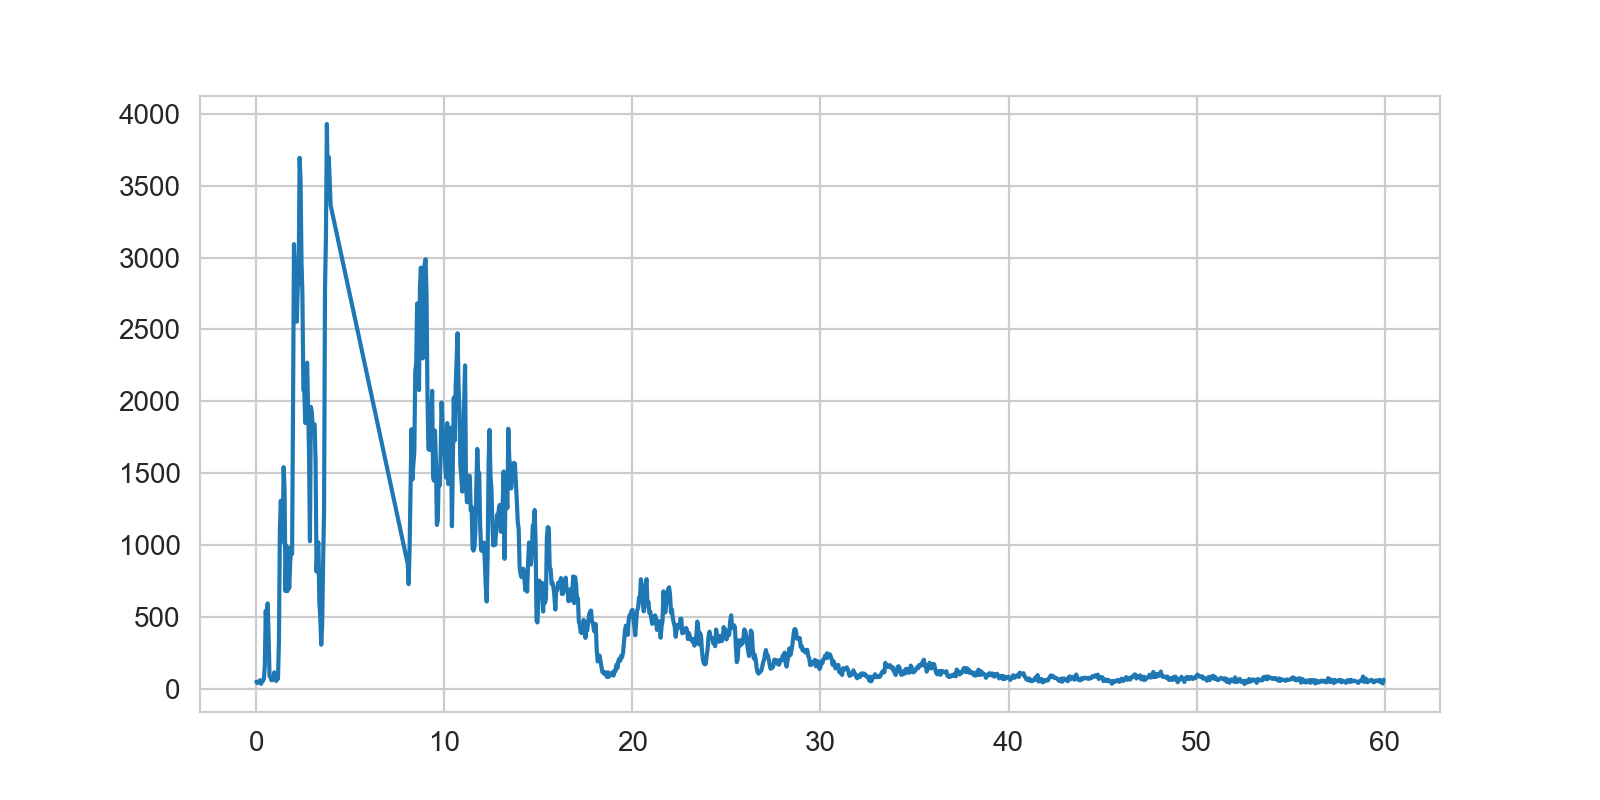

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.plot(time, counts)

In [49]:
lc = Lightcurve(time, counts, skip_checks=True, dt = time[1]-time[0])

### DRW on Data with Cutout

In [50]:
kernel_type = "RN"
mean_type = "skew_gaussian"
params_list = get_gp_params(kernel_type= kernel_type, mean_type = mean_type)

print("parameters list", params_list)

parameters list ['log_arn', 'log_crn', 'log_A', 't0', 'log_sig1', 'log_sig2']


In [51]:
times = lc.time - lc.time[0]
counts = lc.counts

In [52]:
total_time = times[-1] - times[0]
f = 1/(times[1]- times[0])
span = jnp.max(counts) - jnp.min(counts)

# The prior dictionary, with suitable tfpd prior distributions
prior_dict = {
    "t0": tfpd.Uniform(low = 0.0, high = 20.0),
    "log_A": tfpd.Uniform(5, 15),
    "log_sig1": tfpd.Uniform(-1, 3.5),
    "log_sig2": tfpd.Uniform(1, 4.0),
    #"log_freq": tfpd.Uniform(0.3, 5.0),
    #"log_aqpo": tfpd.Uniform(2, 20),
    #"log_cqpo": tfpd.Uniform(-10, 10),
    "log_arn": tfpd.Uniform(2, 20),
    "log_crn": tfpd.Uniform(-10, 10)
}

params_list2 = ["log_arn", "log_crn", "log_A", "t0", "log_sig1", "log_sig2"]

prior_model = get_prior(params_list2, prior_dict)

log_likelihood_model = get_log_likelihood(params_list2, kernel_type= kernel_type, mean_type = mean_type, 
                                          times = times, counts = counts)

In [53]:
from stingray.modeling.gpmodeling import GPResult

gpresult_rn_cutout = GPResult(lc = lc)
gpresult_rn_cutout.sample(prior_model = prior_model, likelihood_model = log_likelihood_model,
               max_samples=1e6)

INFO[2023-11-07 09:02:17,931]: Sanity check...
INFO[2023-11-07 09:02:17,941]: Sanity check passed


Simulation Complete


In [61]:
print("log Evidence: ", gpresult_rn.get_evidence())

log Evidence:  -7945.694905757367


In [54]:
with open(datadir+"fermi_bgo_drw_cutout_deadtimecorr_res.pkl", "wb") as f:
    pickle.dump(gpresult_rn_cutout.results, f)

In [55]:
gpresult_rn_cutout.print_summary()

--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 1253504
# samples: 14000
# slices: 216000.0
# slices / acceptance: 18.0
# likelihood evals / sample: 89.5
# likelihood evals / slice: 5.8
--------
logZ=-7159.47 +- 0.2
H=7200.0
ESS=1607
--------
log_A: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_A: 7.725 +- 0.068 | 7.639 / 7.724 / 7.811 | 7.771 | 7.771
--------
log_arn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_arn: 11.49 +- 0.15 | 11.32 / 11.48 / 11.69 | 11.45 | 11.45
--------
log_crn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_crn: 0.83 +- 0.15 | 0.62 / 0.84 / 1.02 | 0.86 | 0.86
--------
log_sig1: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_sig1: -0.66 +- 0.23 | -0.94 / -0.69 / -0.36 | -0.97 | -0.97
--------
log_sig2: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_sig2: 2.26 +- 0.079 | 2.162 / 2.261 / 2.36

<IPython.core.display.Javascript object>


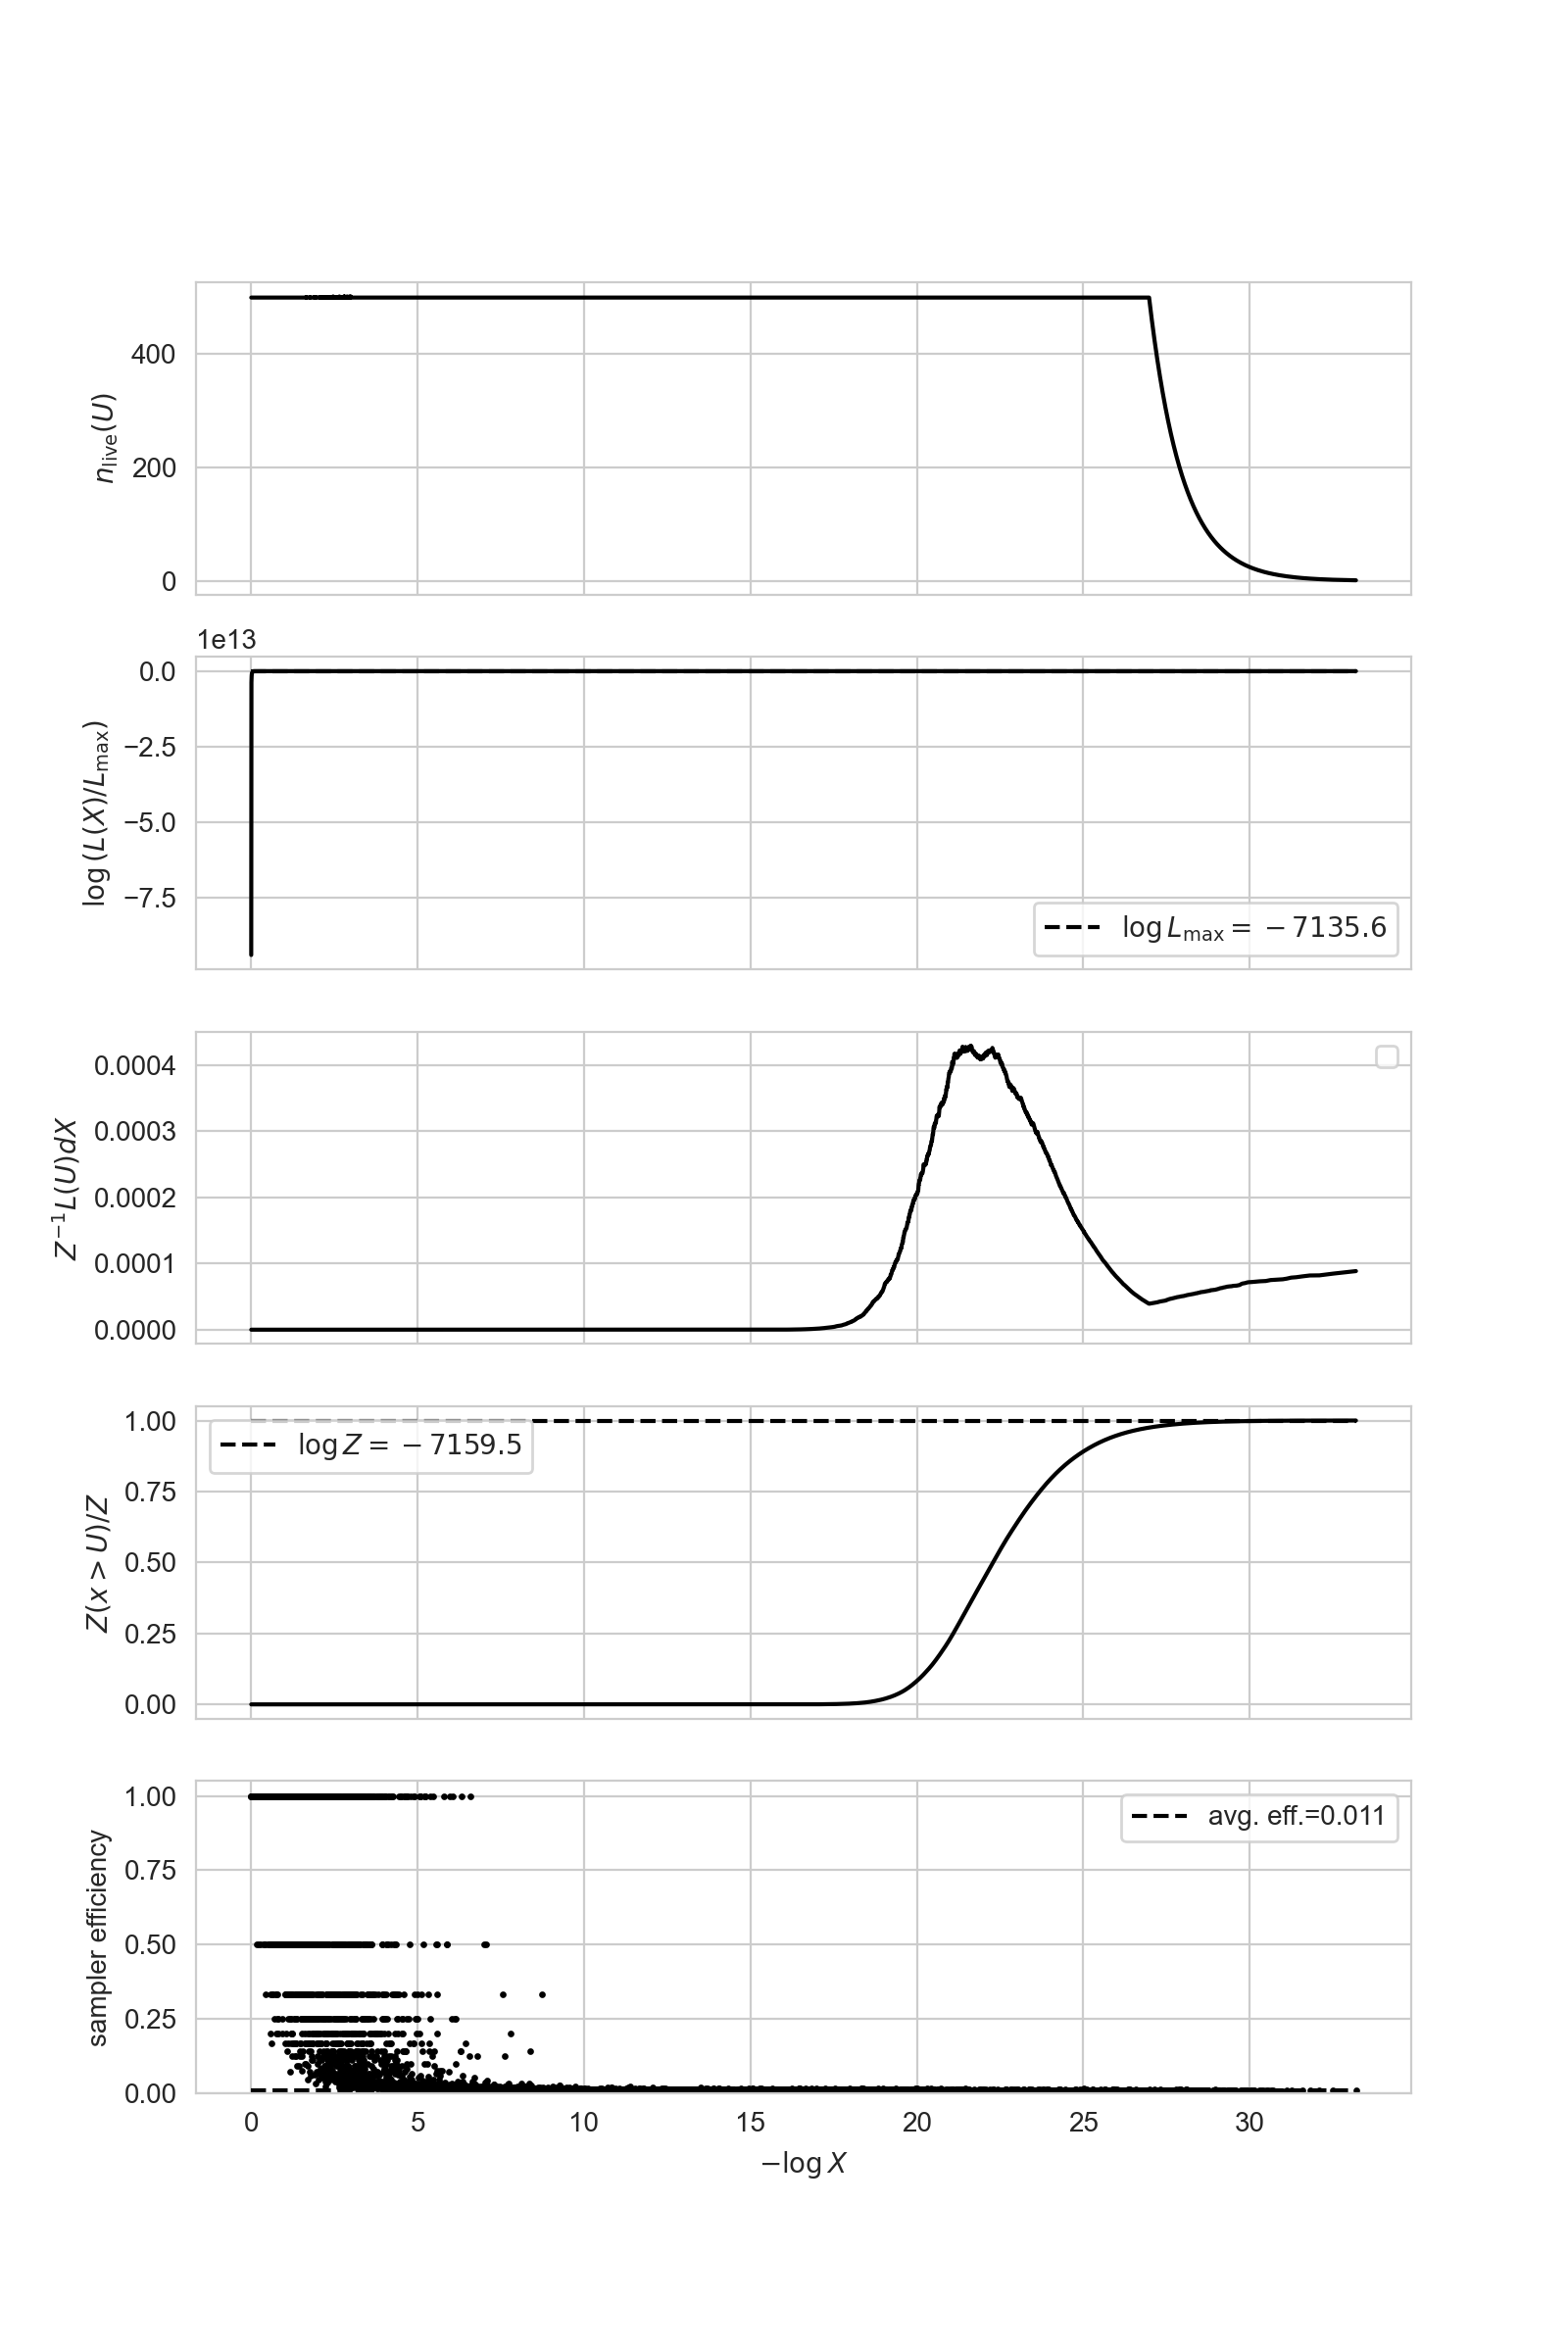

WARNING[2023-11-07 09:28:11,907]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [56]:
gpresult_rn_cutout.exact_ns.plot_diagnostics(gpresult_rn_cutout.results)

<IPython.core.display.Javascript object>


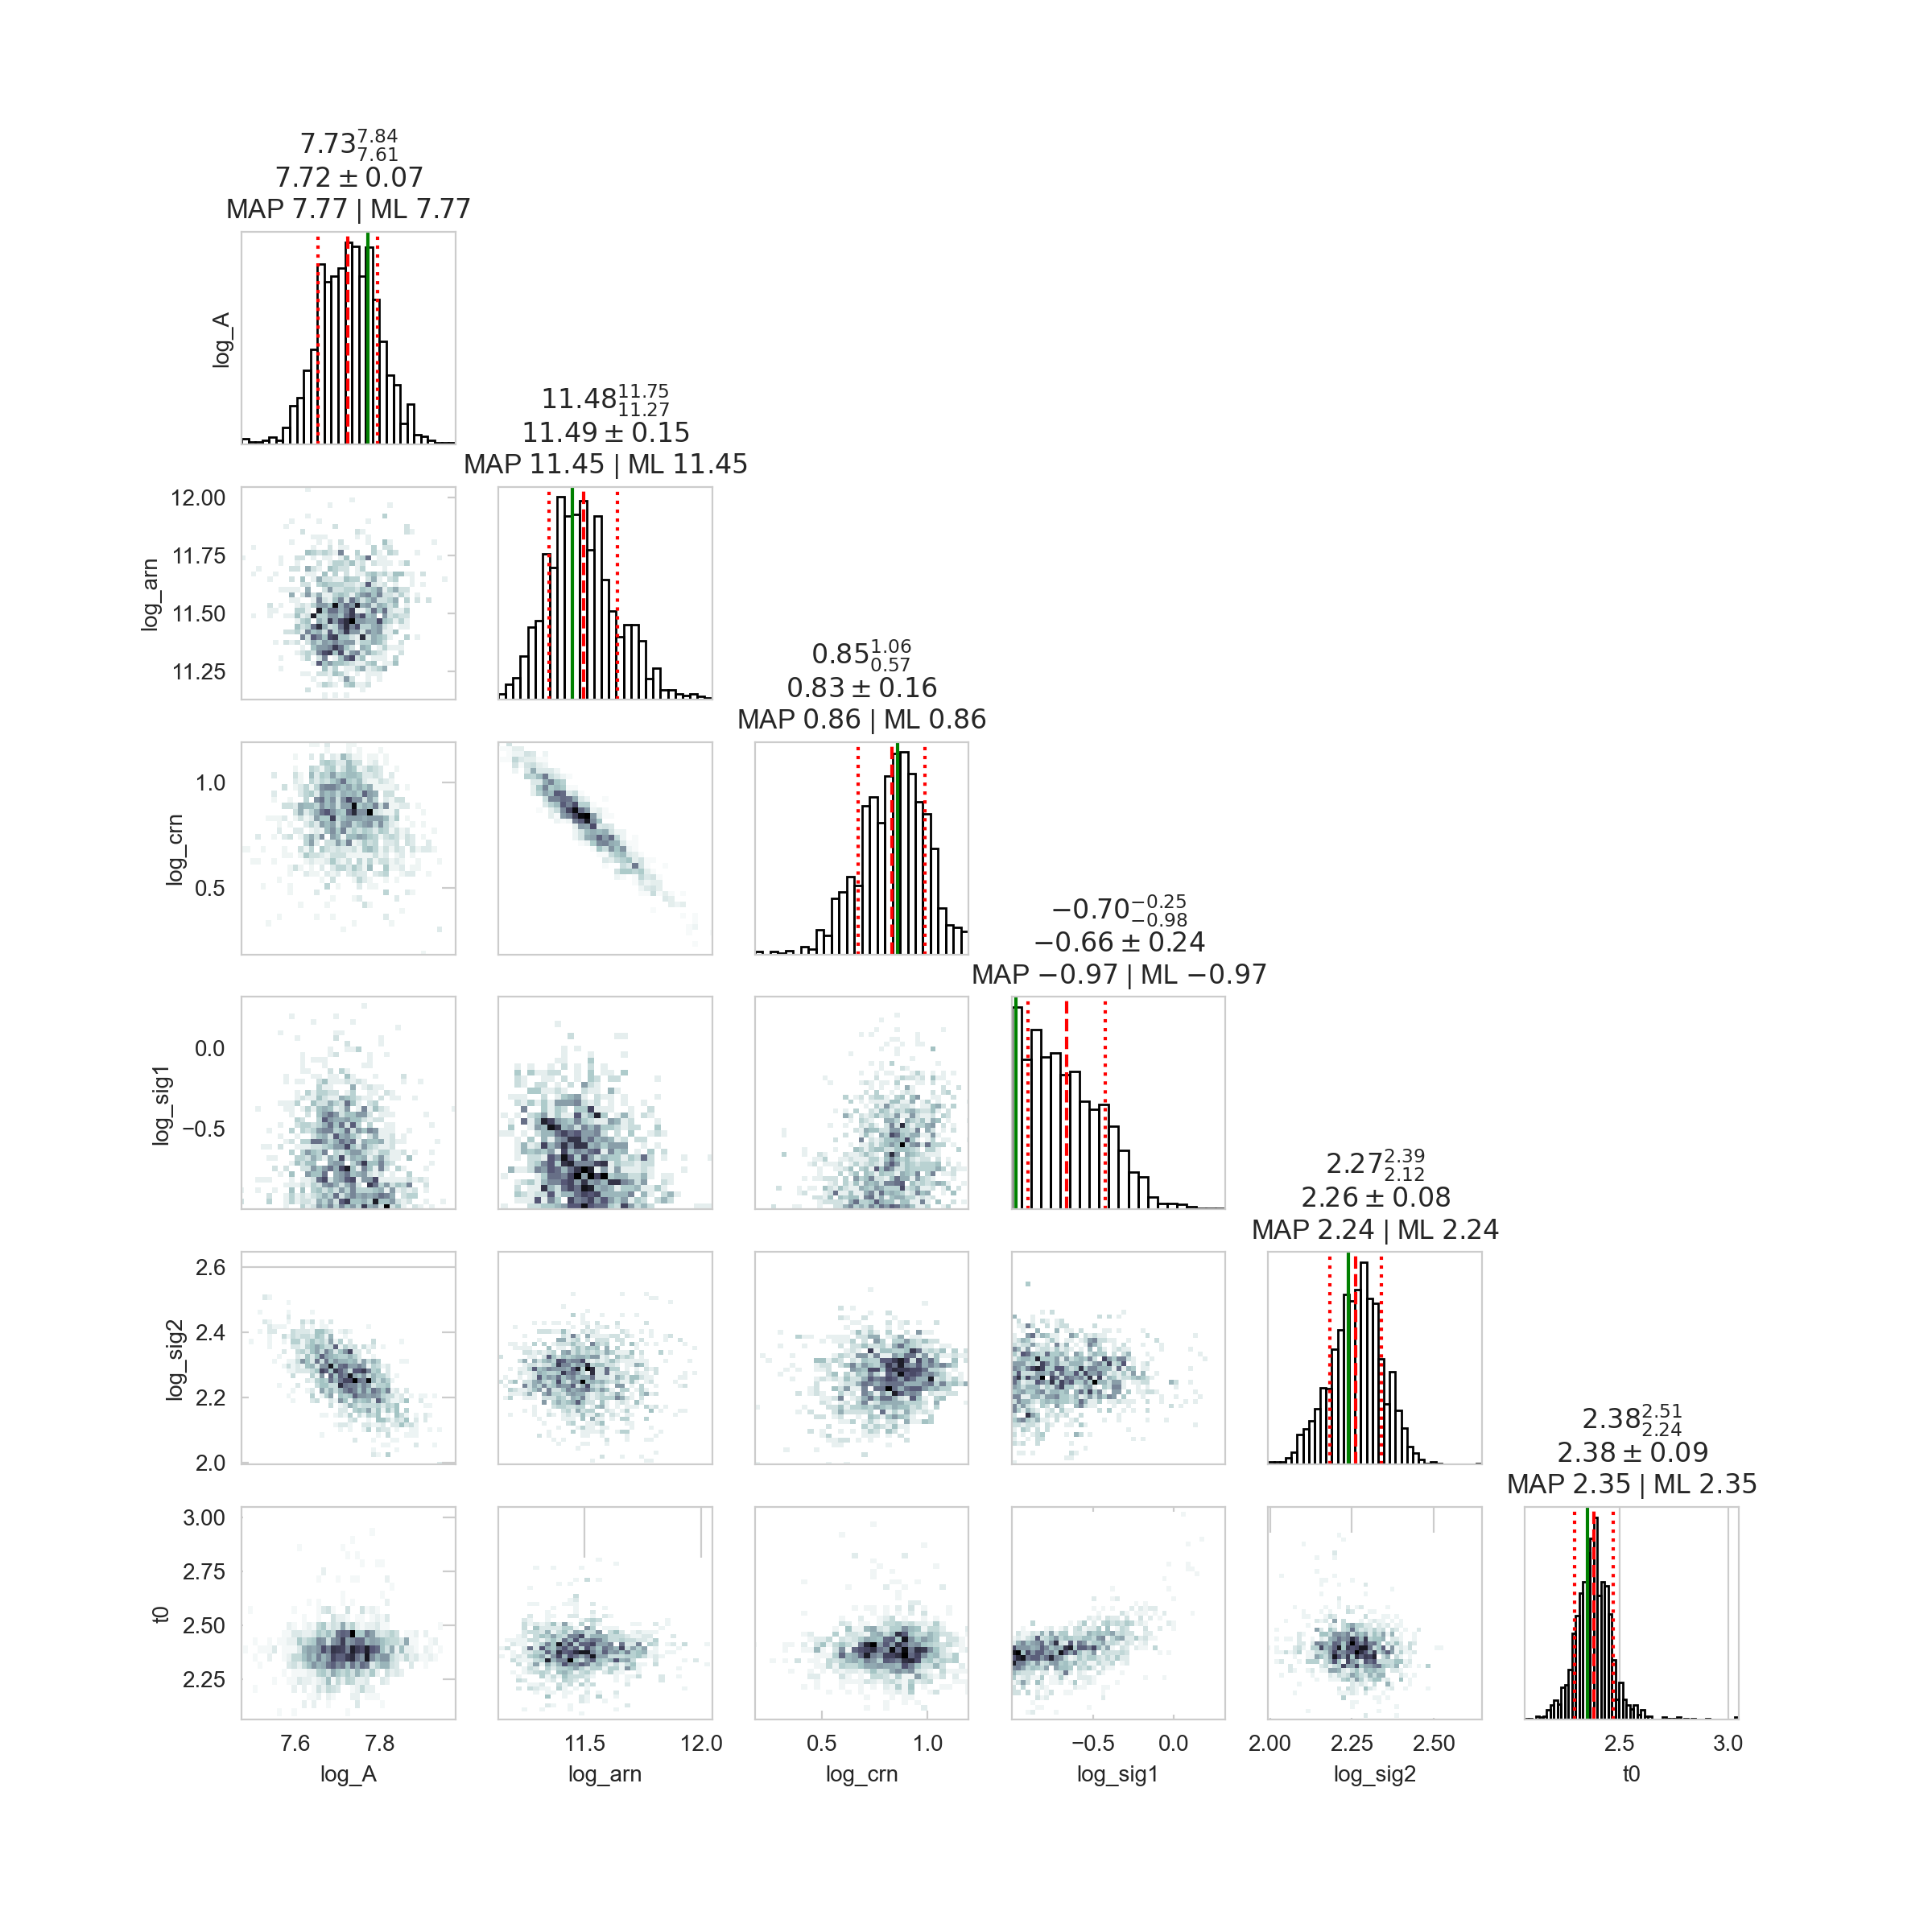

In [57]:
gpresult_rn_cutout.plot_cornerplot()

Let's write a function to plot the posterior predictive distribution (sort of):

<IPython.core.display.Javascript object>


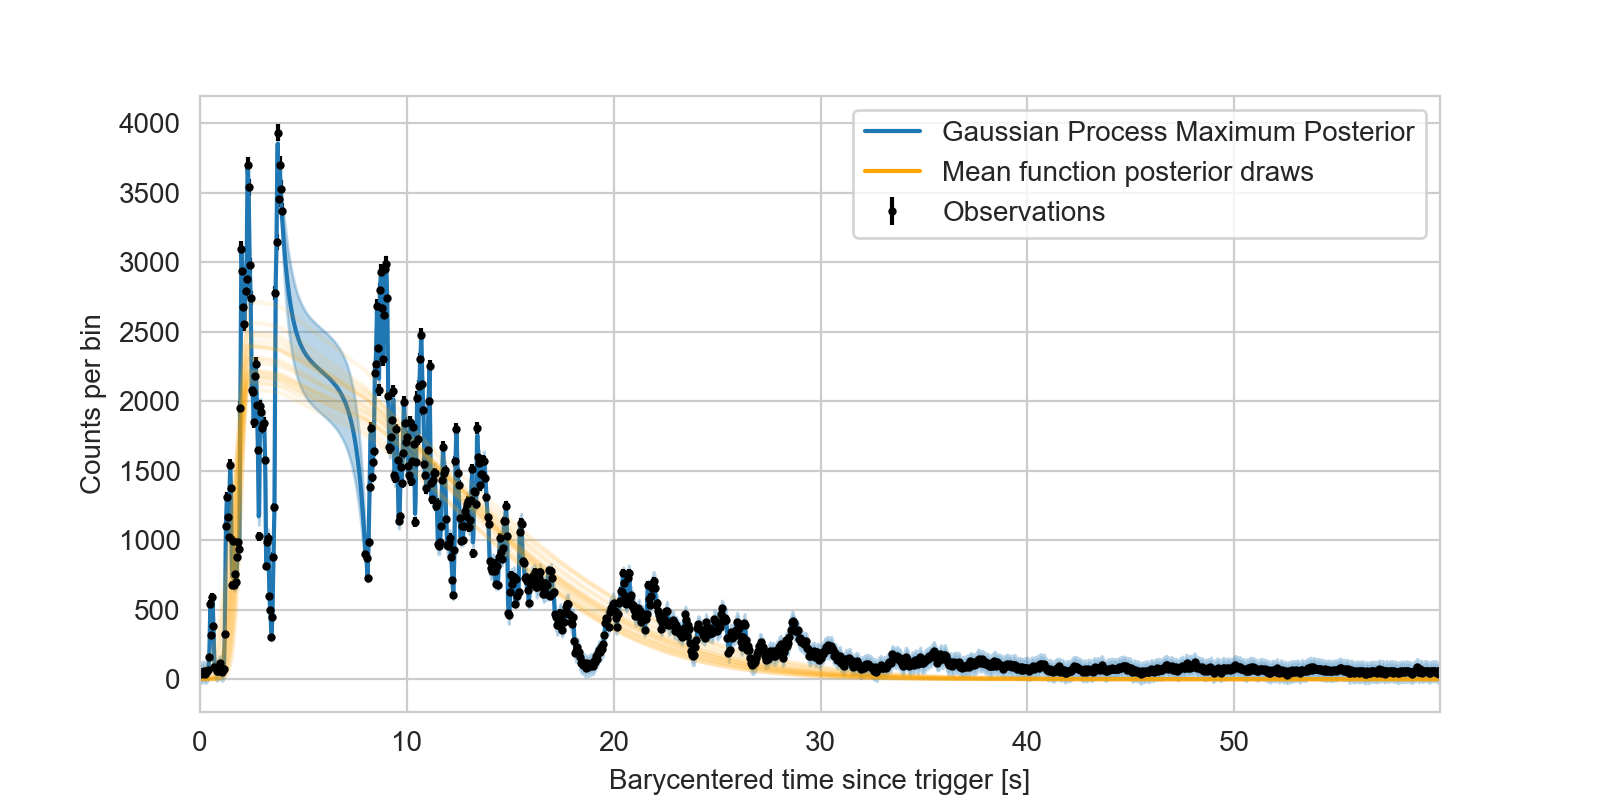

Resampling done, calculating maximum posterior model ...
skew_gaussian
GP calculated, plotting GP and data ...
calculating and plotting mean functions ...


Text(0, 0.5, 'Counts per bin')

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax = plot_posterior_predictive(lc, gpresult_rn_cutout, kernel_type, mean_type, 
                               nmean=20, ngrid=3000, ax=ax, rkey=None)

ax.set_xlim(lc.time[0], lc.time[-1])
ax.set_xlabel("Barycentered time since trigger [s]")
ax.set_ylabel("Counts per bin")

### QPO Model, Cut-out Data

In [59]:
kernel_type = "QPO_plus_RN"
mean_type = "skew_gaussian"
params_list = get_gp_params(kernel_type= kernel_type, mean_type = mean_type)

print("parameters list", params_list)

parameters list ['log_arn', 'log_crn', 'log_aqpo', 'log_cqpo', 'log_freq', 'log_A', 't0', 'log_sig1', 'log_sig2']


In [60]:
total_time = times[-1] - times[0]
f = 1/(times[1]- times[0])
span = jnp.max(counts) - jnp.min(counts)

# The prior dictionary, with suitable tfpd prior distributions
prior_dict = {
    "t0": tfpd.Uniform(low = 0.0, high = 20.0),
    "log_A": tfpd.Uniform(5, 15),
    "log_sig1": tfpd.Uniform(-1, 3.5),
    "log_sig2": tfpd.Uniform(1, 4.0),
    "log_freq": tfpd.Uniform(np.log(0.1), np.log(5.0)),
    "log_aqpo": tfpd.Uniform(2, 20),
    "log_cqpo": tfpd.Uniform(-10, 10),
    "log_arn": tfpd.Uniform(2, 20),
    "log_crn": tfpd.Uniform(-10, 10)
}

#params_list2 = ["log_arn", "log_crn", "log_A", "t0", "log_sig1", "log_sig2"]

prior_model = get_prior(params_list, prior_dict)

log_likelihood_model = get_log_likelihood(params_list, kernel_type= kernel_type, mean_type = mean_type, 
                                          times = times, counts = counts)

In [61]:
from stingray.modeling.gpmodeling import GPResult

gpresult_qporn_cutout = GPResult(lc = lc)
gpresult_qporn_cutout.sample(prior_model = prior_model, likelihood_model = log_likelihood_model,
               max_samples=1e6, num_live_points=2000)

INFO[2023-11-07 09:28:39,022]: Sanity check...
INFO[2023-11-07 09:28:39,030]: Sanity check passed


Simulation Complete


In [62]:
print("log Evidence: ", gpresult_rn_cutout.get_evidence())

log Evidence:  -7159.4709844172085


In [63]:
print("log Evidence: ", gpresult_qporn_cutout.get_evidence())

log Evidence:  -7143.2399647516995


In [64]:
gpresult_qporn_cutout.get_evidence() - gpresult_rn_cutout.get_evidence()

Array(16.23101967, dtype=float64)

In [65]:
with open(datadir+"fermi_bgo_drw_qpo_cutout_deadtimecorr_res.pkl", "wb") as f:
    pickle.dump(gpresult_qporn_cutout.results, f)

In [66]:
gpresult_qporn_cutout.print_summary()

--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 11486843
# samples: 78000
# slices: 1836000.0
# slices / acceptance: 27.0
# likelihood evals / sample: 147.3
# likelihood evals / slice: 6.2
--------
logZ=-7143.24 +- 0.12
H=7100.0
ESS=9167
--------
log_A: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_A: 7.715 +- 0.075 | 7.618 / 7.719 / 7.807 | 7.754 | 7.754
--------
log_aqpo: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_aqpo: 8.44 +- 0.65 | 7.75 / 8.38 / 9.12 | 8.64 | 8.64
--------
log_arn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_arn: 11.49 +- 0.23 | 11.3 / 11.48 / 11.69 | 11.52 | 11.52
--------
log_cqpo: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_cqpo: -3.59 +- 0.84 | -4.59 / -3.64 / -2.64 | -4.05 | -4.05
--------
log_crn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_crn: 0.69 +- 0.68 | 0.53 / 0.75 / 0.94

<IPython.core.display.Javascript object>


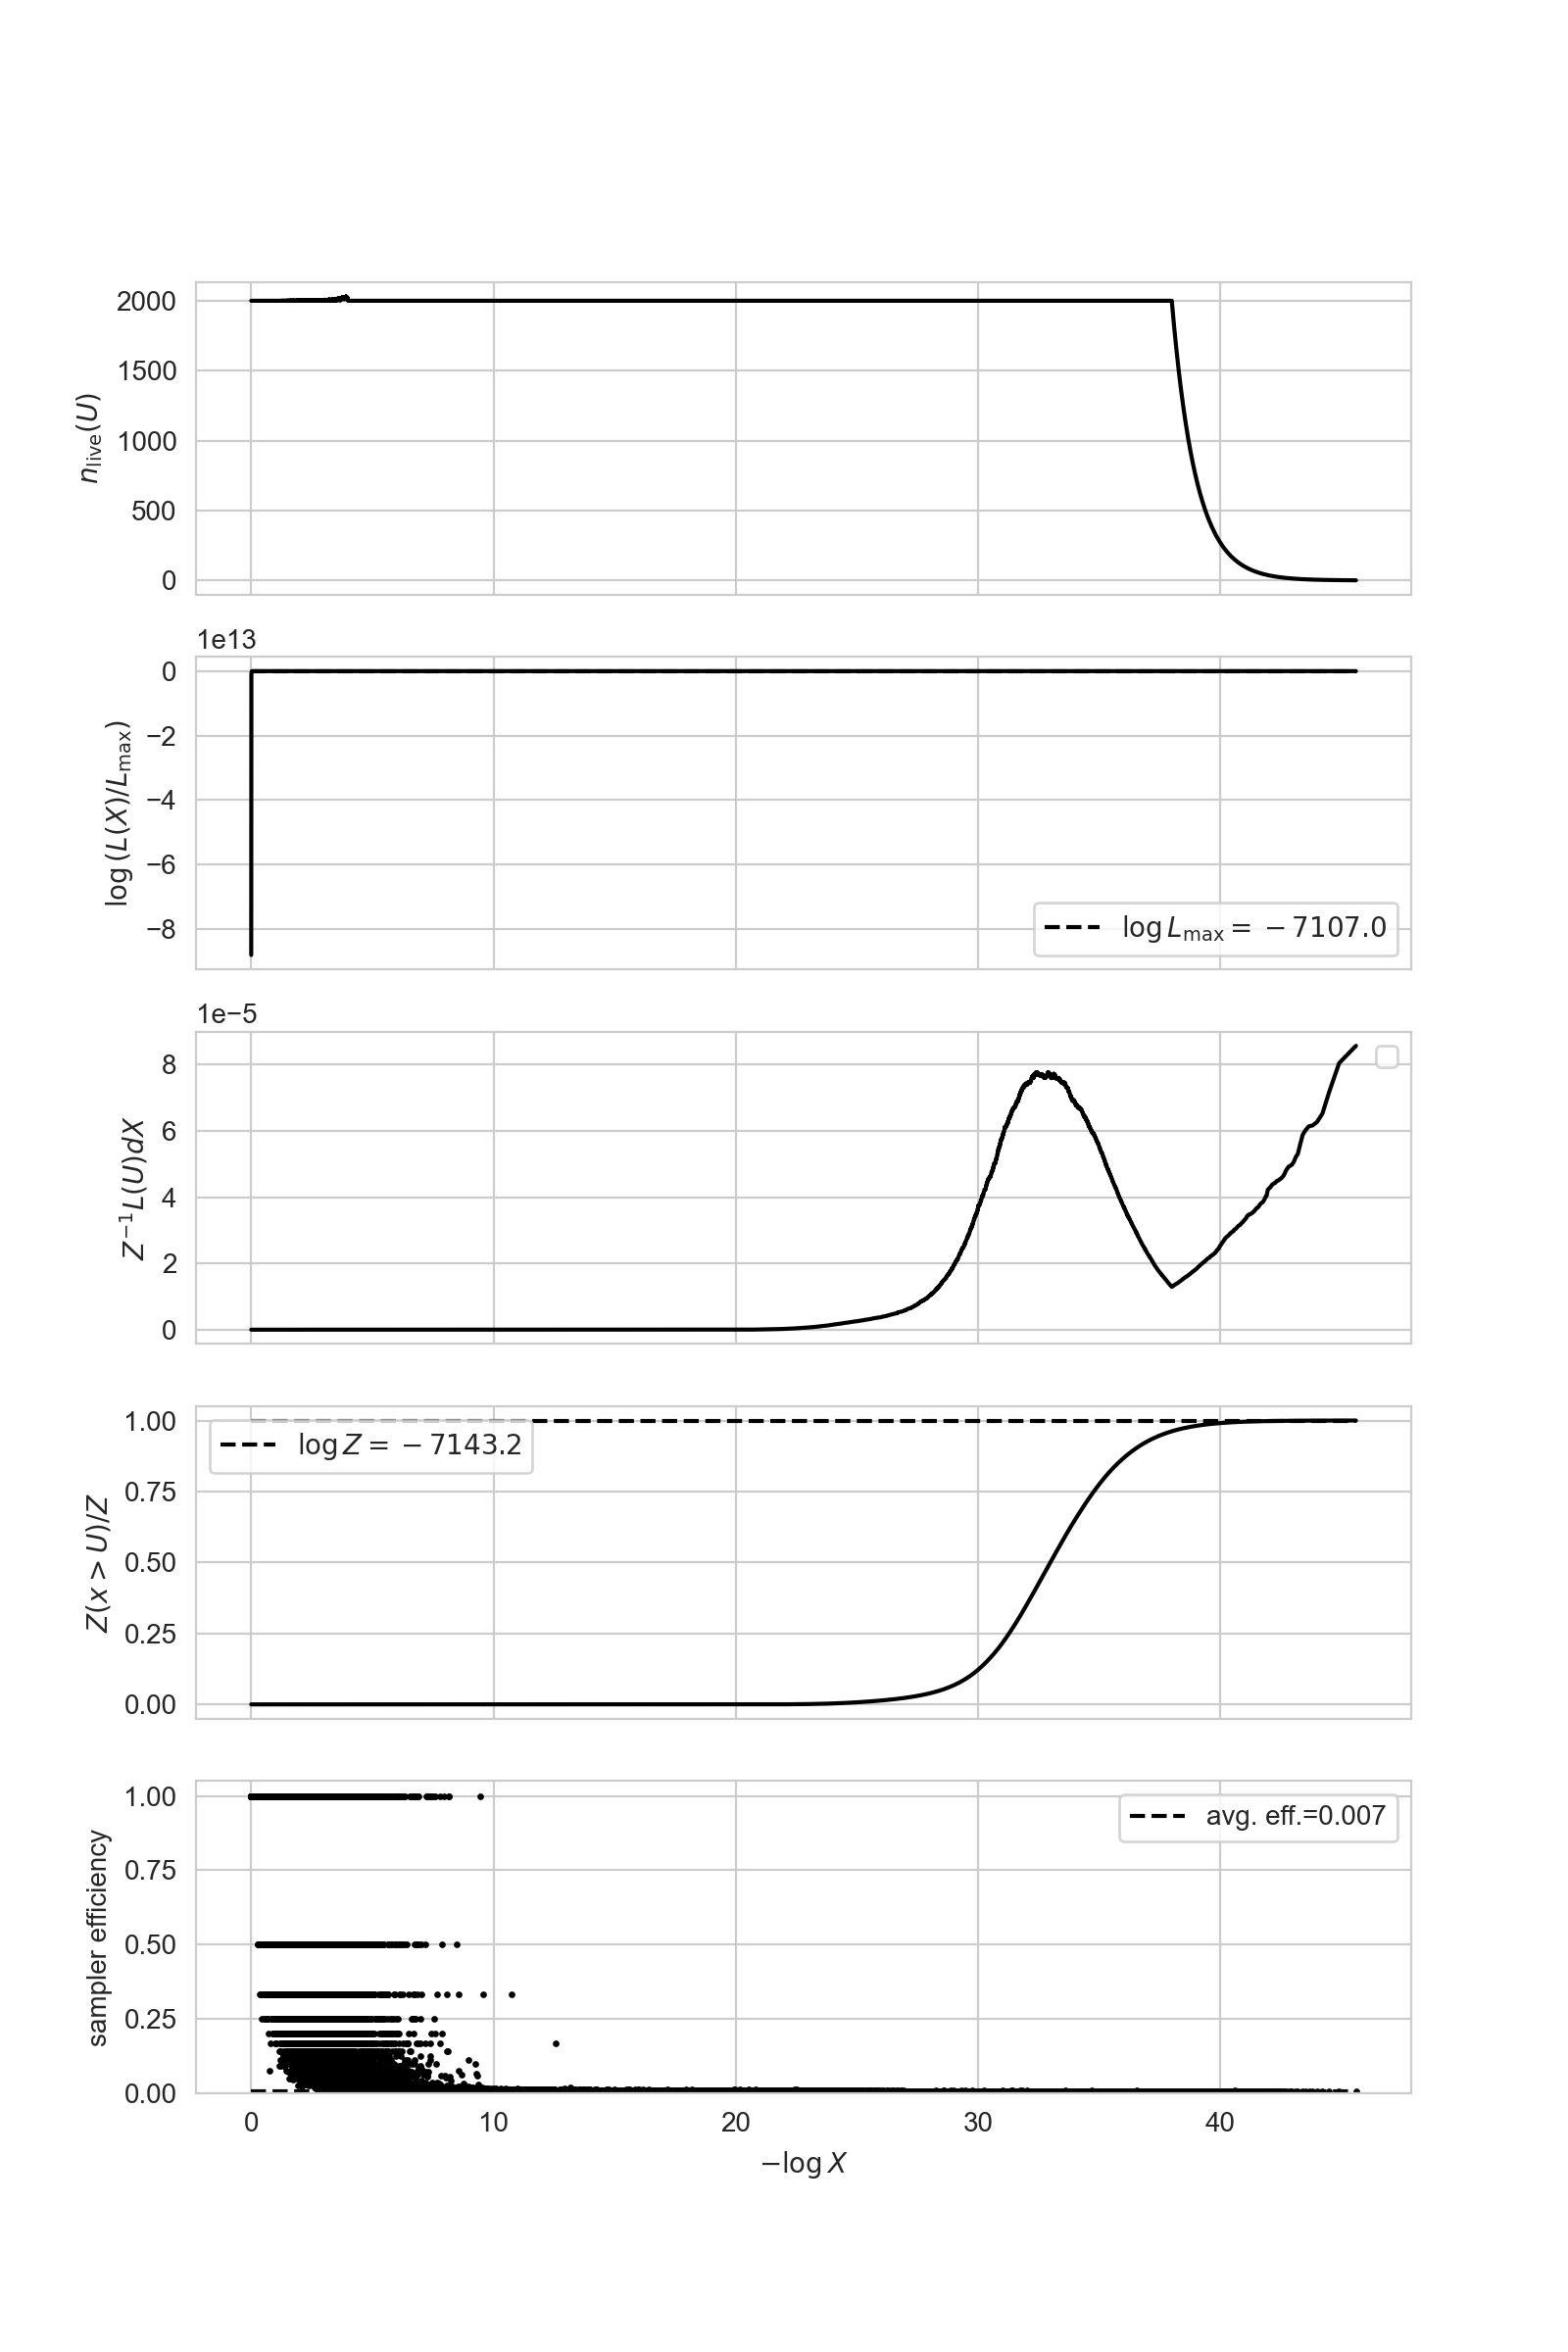

WARNING[2023-11-07 11:37:22,163]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [67]:
gpresult_qporn_cutout.exact_ns.plot_diagnostics(gpresult_qporn_cutout.results)

<IPython.core.display.Javascript object>


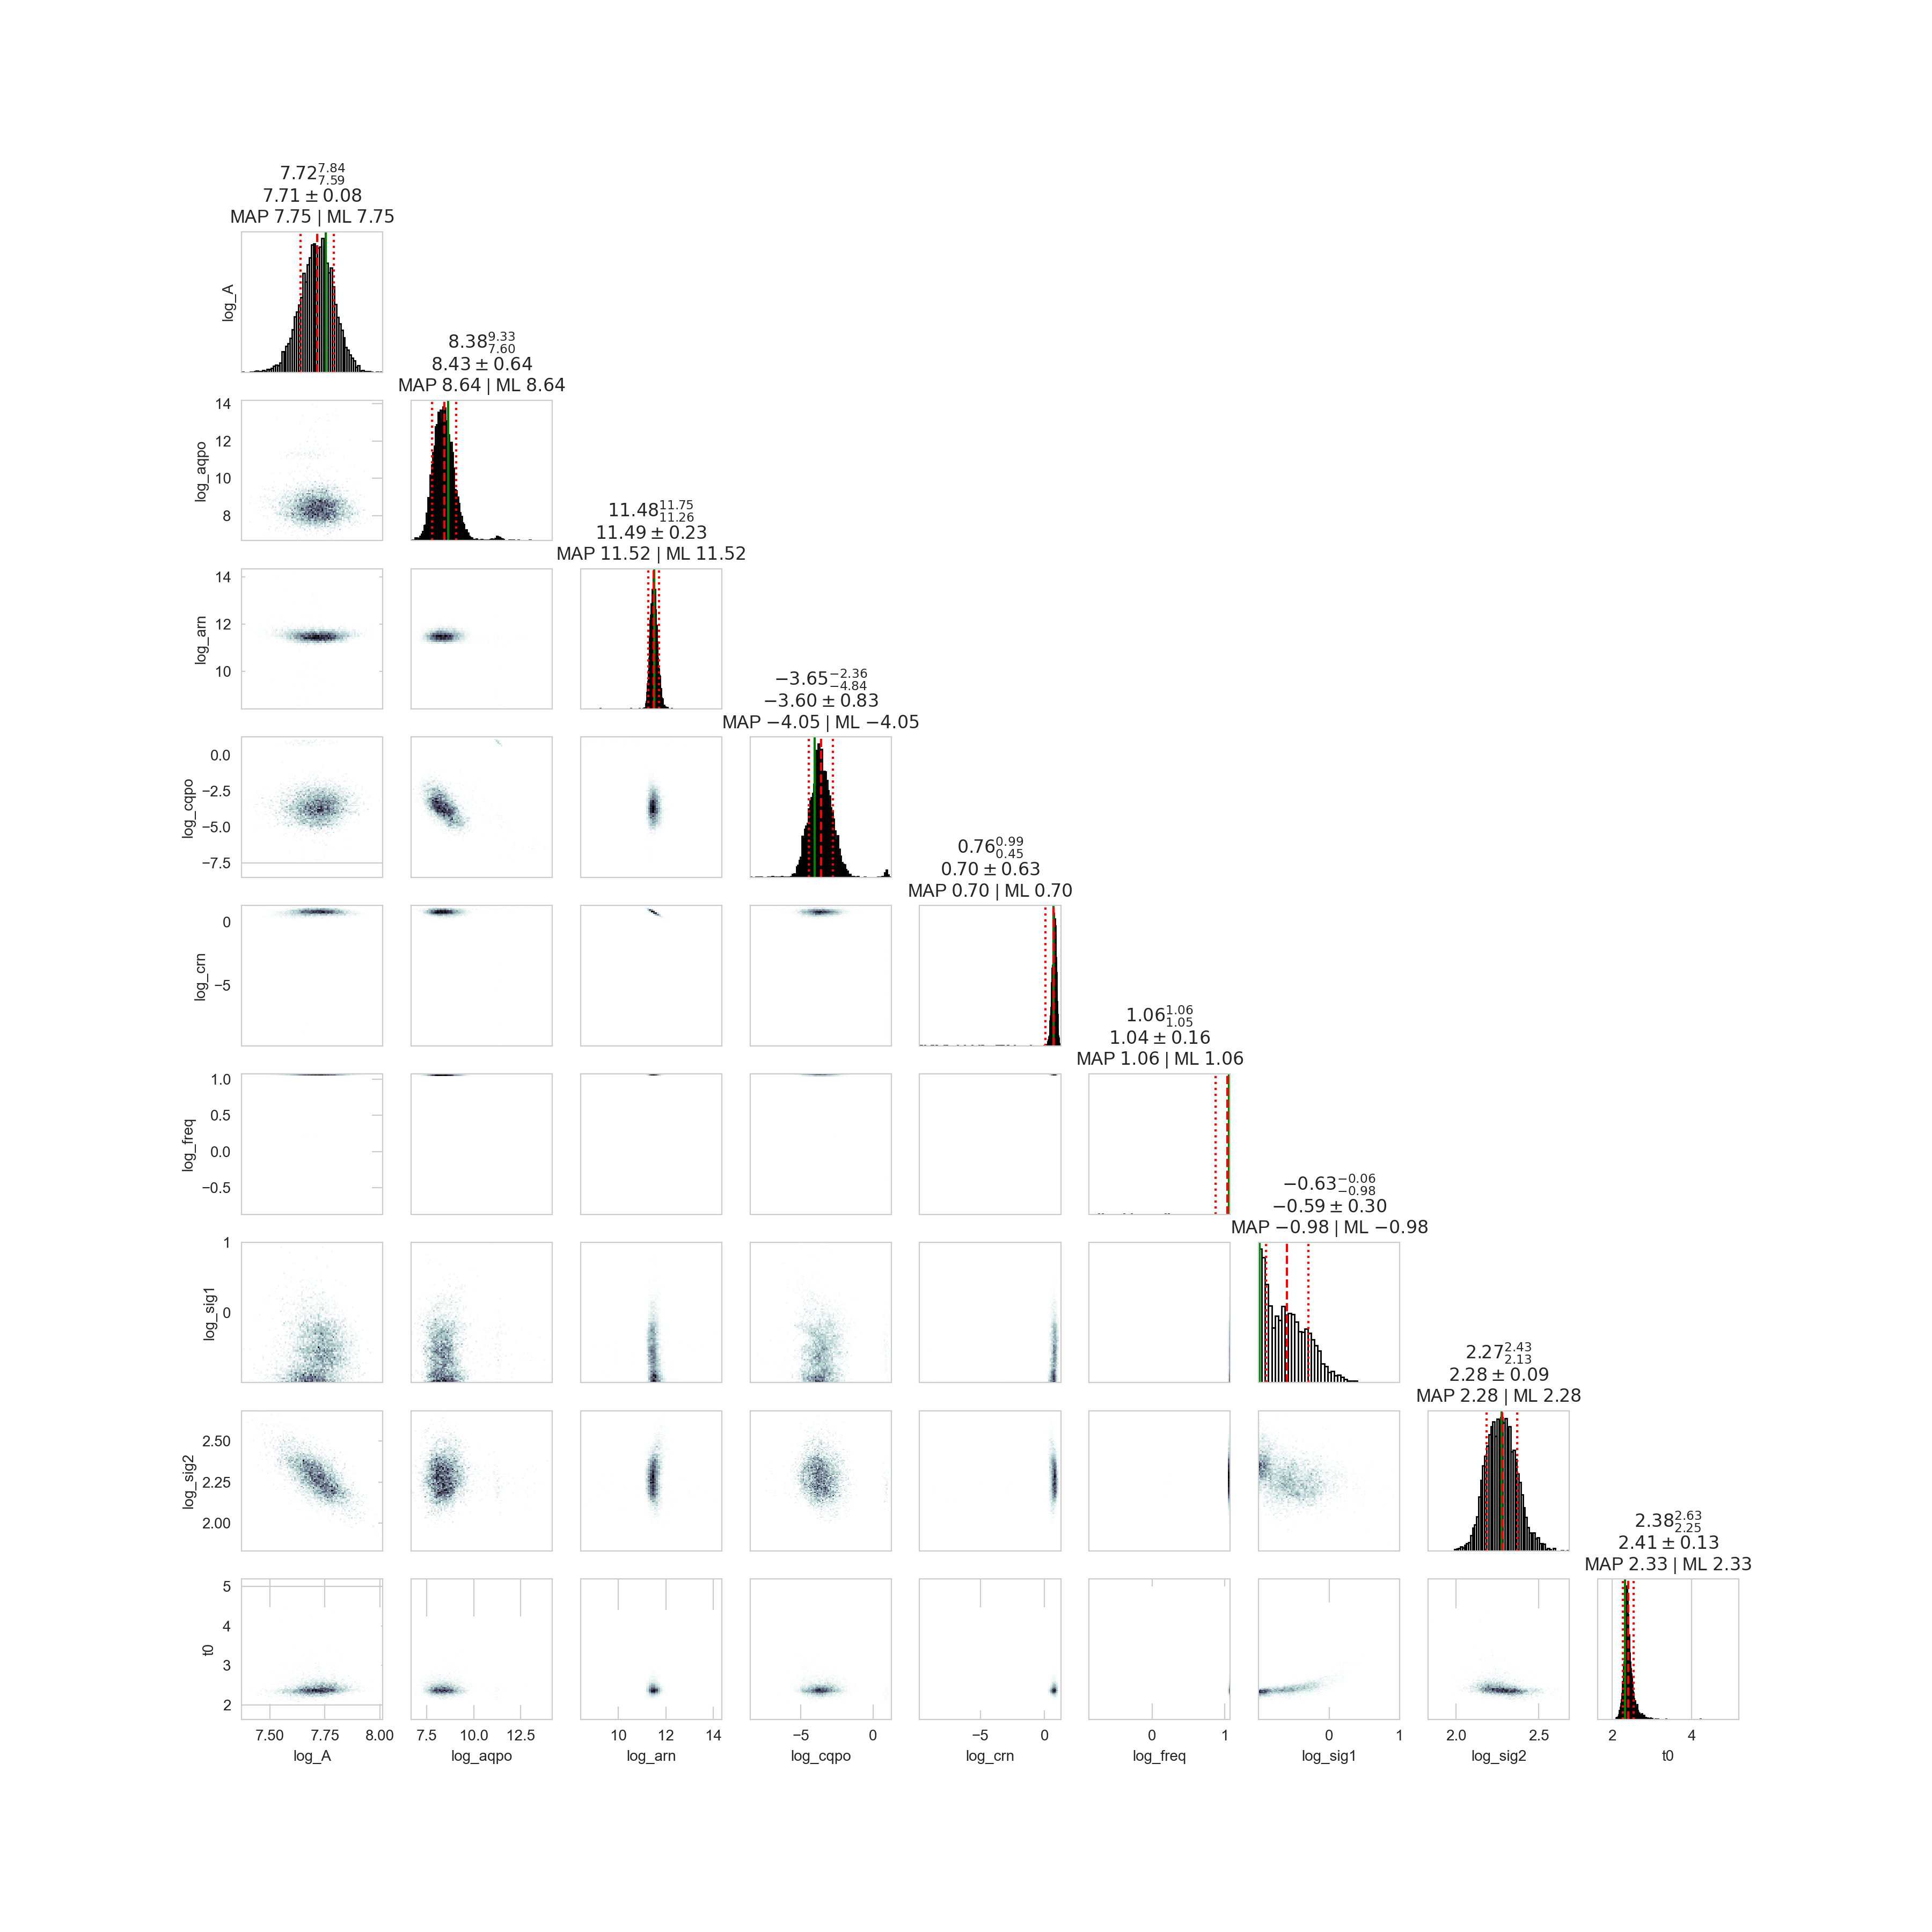

In [69]:
gpresult_qporn_cutout.plot_cornerplot()

<IPython.core.display.Javascript object>


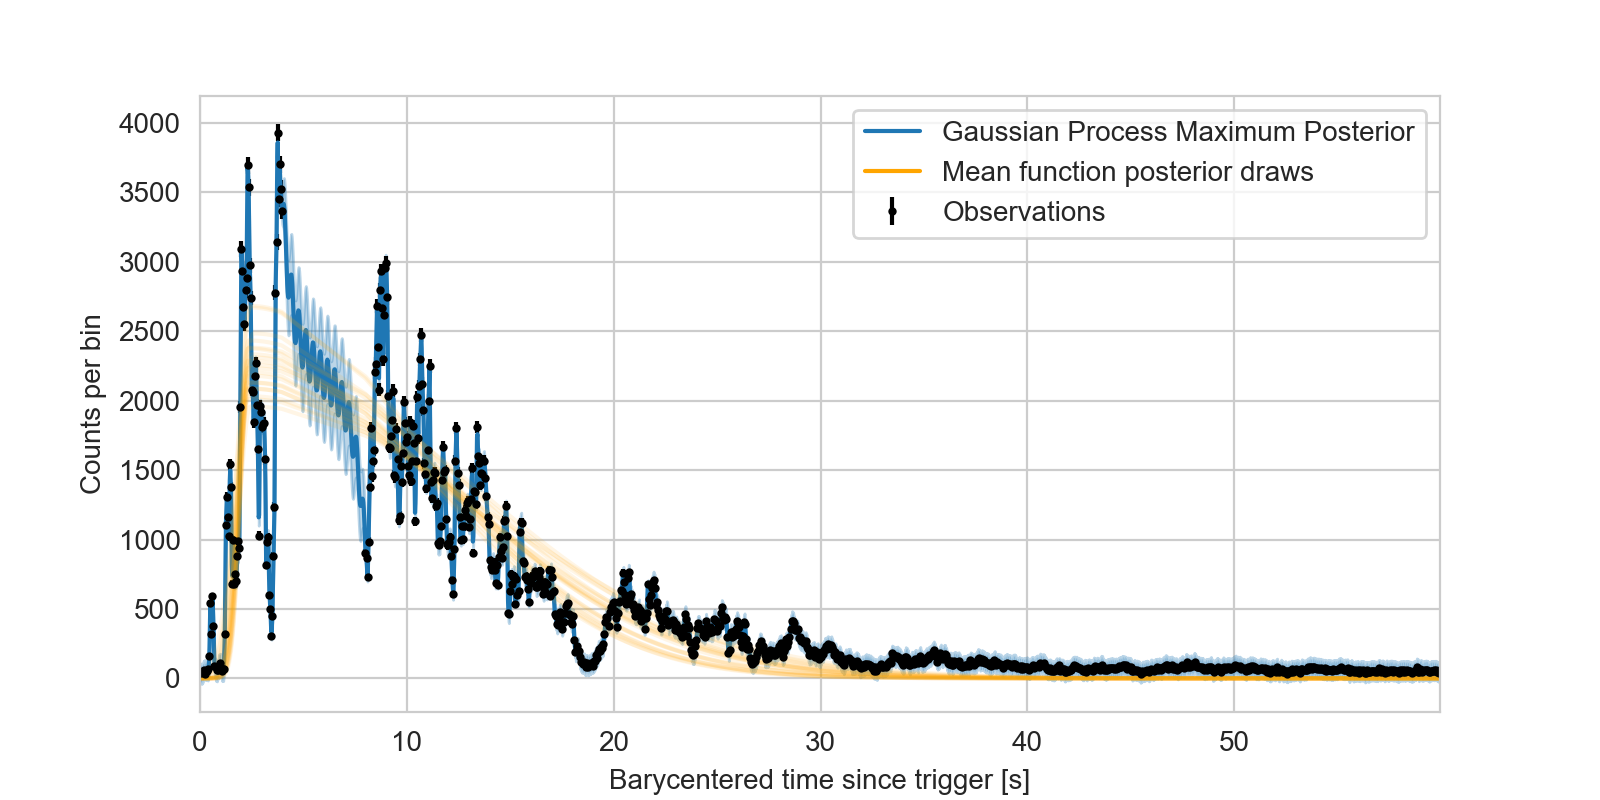

Resampling done, calculating maximum posterior model ...
skew_gaussian
GP calculated, plotting GP and data ...
calculating and plotting mean functions ...


Text(0, 0.5, 'Counts per bin')

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax = plot_posterior_predictive(lc, gpresult_qporn_cutout, kernel_type, mean_type, 
                               nmean=20, ngrid=3000, ax=ax, rkey=None)

ax.set_xlim(lc.time[0], lc.time[-1])
ax.set_xlabel("Barycentered time since trigger [s]")
ax.set_ylabel("Counts per bin")

Okay, that looks better. Phew. Let's plot the QPO frequency:

<IPython.core.display.Javascript object>


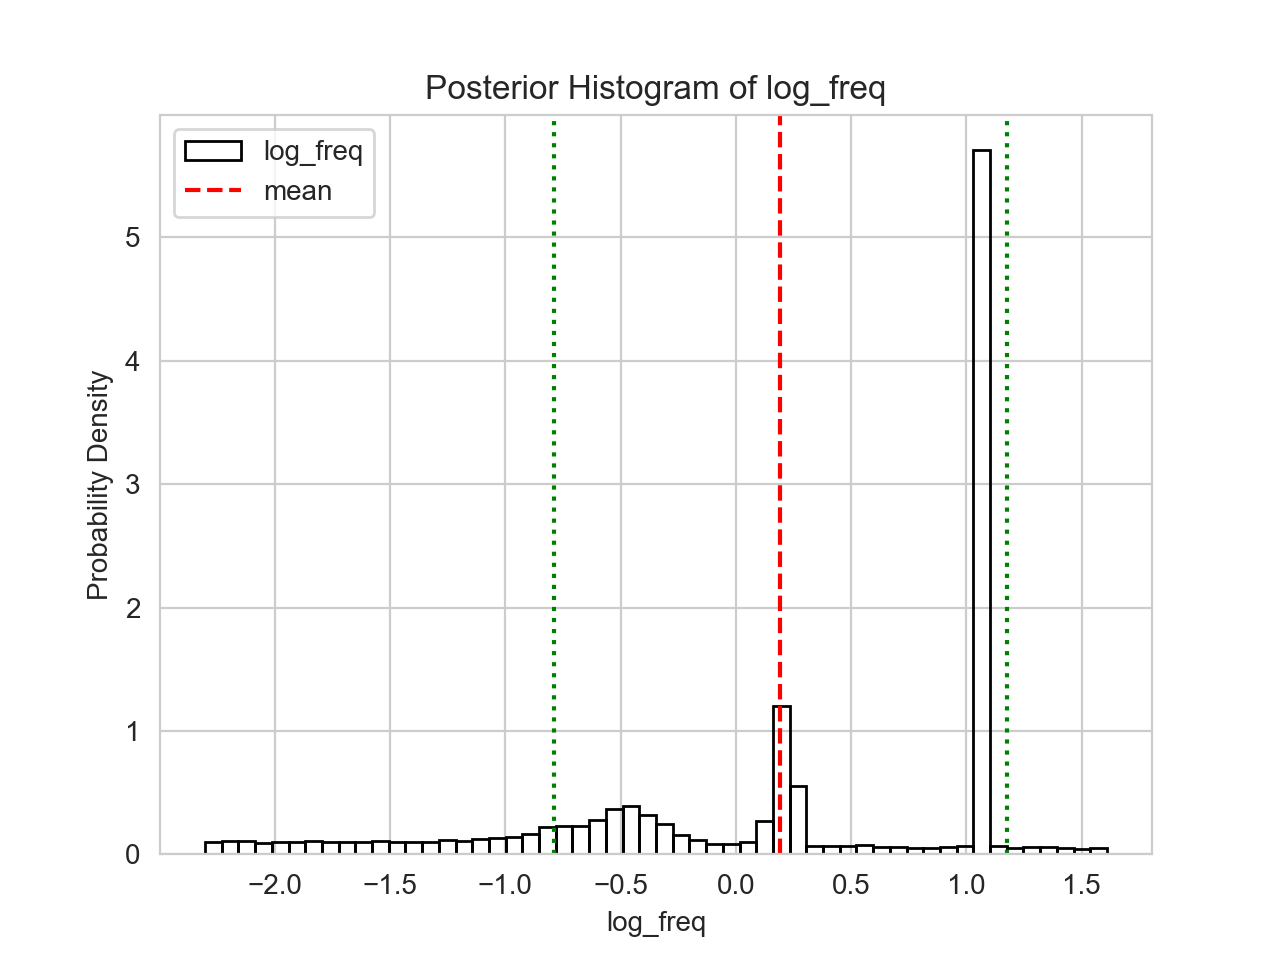

<module 'matplotlib.pyplot' from '/opt/miniconda3/envs/grbsearch/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [71]:
plt.figure()
gpresult_qporn_cutout.posterior_plot("log_freq")

In [72]:
samples = gpresult_qporn_cutout.results.samples["log_freq"]
rkey = random.PRNGKey(1234)

log_p = gpresult_qporn_cutout.results.log_dp_mean #log-prob
nsamples = gpresult_qporn_cutout.results.total_num_samples # number of samples

weights = jnp.where(jnp.isfinite(samples), jnp.exp(log_p), 0.0)
log_weights = jnp.where(jnp.isfinite(samples), log_p, -jnp.inf)
freq_resampled = resample(
    rkey, samples, log_weights, S=max(10, int(gpresult_qporn_cutout.results.ESS)), replace=True
)

In [73]:
freq = np.exp(freq_resampled)
period = 1.0/freq

In [74]:
period

array([0.34647971, 0.34753574, 0.34723952, ..., 0.34772567, 0.34816374,
       0.34873033])

In [75]:
1./0.347

2.8818443804034586

<IPython.core.display.Javascript object>


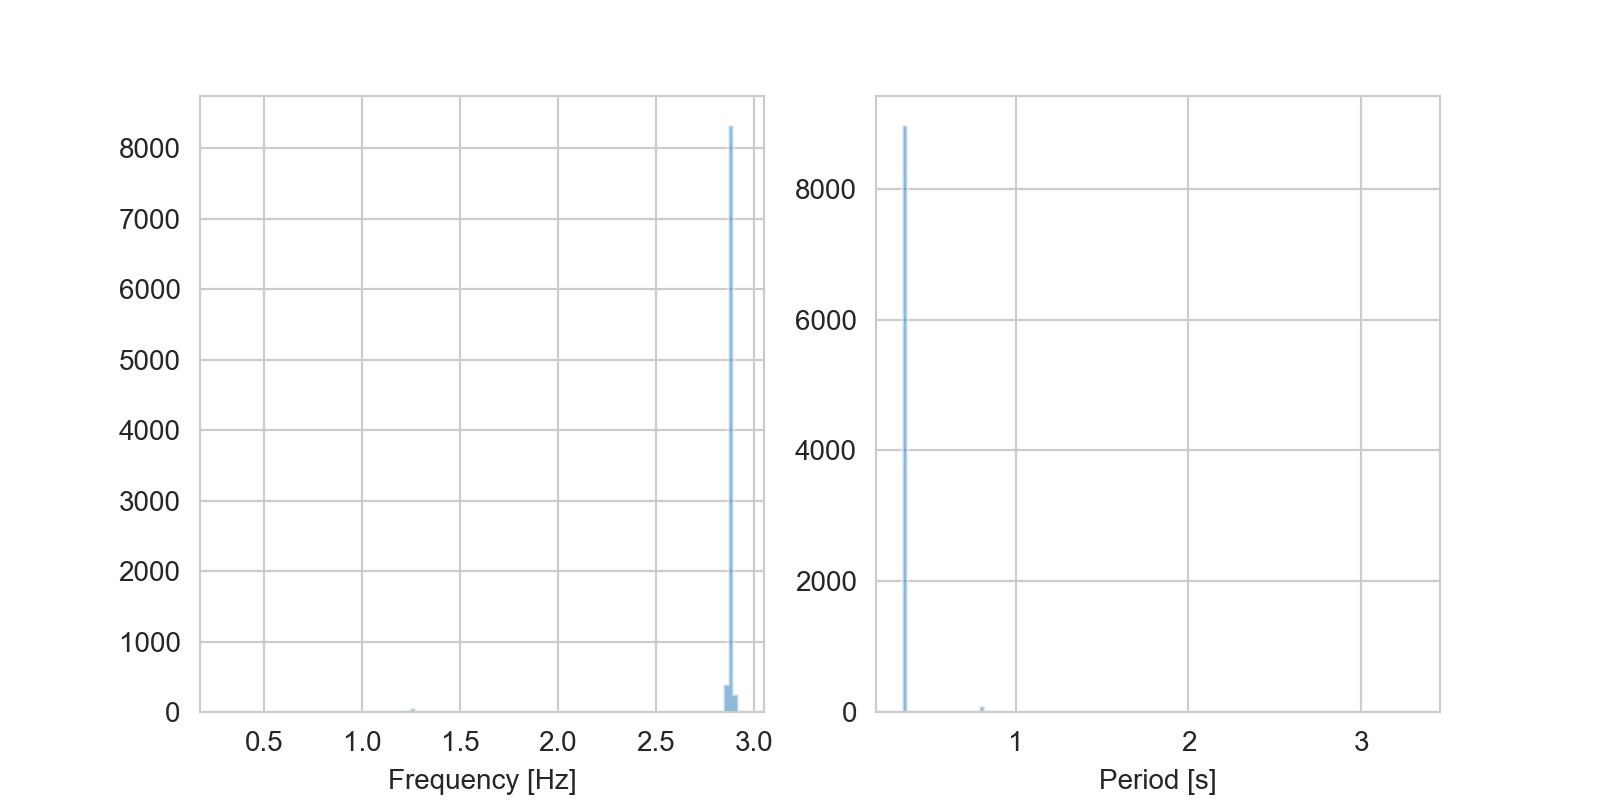

Text(0.5, 0, 'Period [s]')

In [76]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

ax1.hist(freq, bins=100, histtype="stepfilled", alpha=0.5)
ax1.set_xlabel("Frequency [Hz]")

ax2.hist(period, bins=100, histtype="stepfilled", alpha=0.5)
ax2.set_xlabel("Period [s]")

In [77]:
np.log10(np.exp(gpresult_qporn_cutout.get_evidence() - gpresult_rn_cutout.get_evidence()))

7.049042276393696

Note: looks like we have a double-peaked posterior. Maybe I should add another component? 

## Two-Component QPO Model